In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
! pip install "transformers" "pytorch-lightning"

     |████████████████████████████████| 4.2 MB 9.9 MB/s 
     |████████████████████████████████| 584 kB 47.4 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
     |████████████████████████████████| 596 kB 38.1 MB/s 
     |████████████████████████████████| 409 kB 35.4 MB/s 
     |████████████████████████████████| 136 kB 53.4 MB/s 
     |████████████████████████████████| 1.1 MB 51.7 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 63.2 MB/s 
     |████████████████████████████████| 271 kB 60.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import json
import pandas as pd
import numpy as np
import time
import heapq

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline 
from yellowbrick.cluster import KElbowVisualizer

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# likes_path = "/content/drive/MyDrive/Tesi/easytour-likes-2022-03MAR-21.json"
# schede_path = "/content/drive/MyDrive/Tesi/easytour-schede-2022-03MAR-21.json"
# data_path = "/content/drive/MyDrive/Tesi/data.csv"

In [7]:
likes_path = "/content/drive/MyDrive/Tesi/kuriu-likes-apr.json"
schede_path = "/content/drive/MyDrive/Tesi/kuriu-schede-apr.json"
data_path = "/content/drive/MyDrive/Tesi/data-APR.csv"

In [8]:
df_schede = pd.read_json(schede_path)
df_likes = pd.read_json(likes_path)
data = pd.read_csv(data_path, encoding_errors='ignore')  

In [9]:
categories = ["aria aperta", "cultura", "food", "sport", "tempo libero", "viaggi"]

In [10]:
df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "counterUseful", "categories", "viewCounter"]]
df_likes_ids = df_likes[["id", "userId"]]

In [11]:
df_schede

,id,userId,userName,documentType,title,description,locations,feature,duration,imageId,...,videoId,version,categories,media,shareType,status,lastUpdate,versionHistory,viewCounter,device
0,62355f98272ae5672fbc3ac7,632,Forestlife Adventure,experience,Spiagge selvagge a Phuket 🇹🇭,"Phuket, il paradiso per gli amanti del sole, d...",[{'photoReference': 'Aap_uEDKOn5xZw8whBhgYdkkO...,[],0,62355c31272ae5672fbc3a9d,...,None,2,[Viaggi],{'photos': [{'fileId': '62355c31272ae5672fbc3a...,SHARED,PUBLISHED,2022-03-19T04:44:08.475Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",7,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A..."
1,620aa536ff8ae67f37cafb06,442,lollo_cata,experience,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,[{'photoReference': 'Aap_uEBCcOt7F8m6JNGvUZJOR...,[],10800000,620aa384ff8ae67f37cafaf9,...,None,4,[Viaggi],{'photos': [{'fileId': '620aa384ff8ae67f37cafa...,SHARED,PUBLISHED,2022-02-14T20:05:09.362Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",419,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'..."
2,622c3b8ac992ca28f33c7f21,571,tiportoviaconme,experience,Escursione al tramonto a Pidurangala Rock,"Nel cuore dello Sri Lanka, nella zona centrale...",[{'photoReference': 'Aap_uECE8sfZDs45_vO9P4A-D...,[],0,622c39dfc992ca28f33c7ef6,...,None,2,[Aria aperta],{'photos': [{'fileId': '622c39dfc992ca28f33c7e...,SHARED,PUBLISHED,2022-03-12T06:19:54.777Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",24,"{'deviceModel': 'OPPO CPH1907', 'deviceOS': 'A..."
3,620a90c8ff8ae67f37caf97f,530,GessicaM,experience,Koh Samui,Dopo il tour di Bangkok vi parlerò del belliss...,[{'photoReference': 'Aap_uECK2Ukxa6hFFTuOwt8N4...,[],3600000,620a9065ff8ae67f37caf956,...,620a90c5ff8ae67f37caf966,4,[Viaggi],{'photos': [{'fileId': '620a9065ff8ae67f37caf9...,SHARED,PUBLISHED,2022-02-16T15:15:51.025Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",453,"{'deviceModel': 'iPhone SE (2nd generation)', ..."
4,622c398cc992ca28f33c7edd,571,tiportoviaconme,experience,"Visita al sito archeologico di Dambulla, Sri L...",Lo Sri Lanka è un paese molto vario e in poco ...,[{'photoReference': 'Aap_uEDcSmwdHtmkJrymQsTW0...,[],0,622c387ec992ca28f33c7e71,...,None,2,[Viaggi],{'photos': [{'fileId': '622c387ec992ca28f33c7e...,SHARED,PUBLISHED,2022-03-12T06:11:24.998Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",12,"{'deviceModel': 'OPPO CPH1907', 'deviceOS': 'A..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,620c32db25398565dadb5867,570,gru1977,experience,"San Pedro, San Rafael, San Antonio 🇨🇴",San Pedro de los Milagros si trova a nord di M...,[{'photoReference': 'Aap_uECmYvam4yQCA0umcZcio...,[],194400000,620c31a325398565dadb5857,...,None,4,[Viaggi],{'photos': [{'fileId': '620c31a325398565dadb58...,SHARED,PUBLISHED,2022-03-02T16:28:46.733Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",39,"{'deviceModel': 'samsung SM-A405FN', 'deviceOS..."
4643,6213b3460f41f86438b07d9c,429,Elle_,experience,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",[{'photoReference': 'Aap_uEASvi2g7Xd91-_ojmvmi...,[],21600000,6213b3000f41f86438b07cad,...,6213b3000f41f86438b07cb2,3,[Viaggi],{'photos': [{'fileId': '6213b3000f41f86438b07c...,SHARED,PUBLISHED,2022-03-01T12:33:30.729Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",41,"{'deviceModel': 'iPhone 8', 'deviceOS': 'iOS',..."
4644,6207b9cdb1d0940f122580b7,570,gru1977,experience,Tutti i colori di Guatapé 🇨🇴,Guatapé è un’esplosione di colori. Non conosco...,[{'photoReference': 'Aap_uEABRi48_gTXe1ygfa22O...,[],72000000,6207b971b1d0940f122580af,...,None,4,[Viaggi],{'photos': [{'fileId': '6207b971b1d0940f122580...,SHARED,PUBLISHED,2022-03-02T16:27:29.935Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",52,"{'deviceModel': 'samsung SM-A405FN', 'deviceOS..."
4645,61f6a3e3306802033034d576,536,Dierre,experience,Avventura in Ecuador - Quilotoa e Cotopaxi,Continuiamo il nostro viaggio sempre a bordo d...,[{'

In [12]:
data

,id,userId,title,description,duration,datePublishing,creationDate,counterUseful,categories,viewCounter,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,62355f98272ae5672fbc3ac7,632,"['spiaggia', 'phuket', 'thailand']","['phuket', 'paradiso', 'amant', 'sole', 'mare'...",0,2022-03-19T04:44:09.503Z,2022-03-19T04:44:08.000+00:00,0,['Viaggi'],7,0,0,0,0,0,1,0.0,31
1,620aa536ff8ae67f37cafb06,442,['tigr'],"['marcio', 'maltrattamento', 'animal', 'andar'...",10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,0,['Viaggi'],419,0,0,0,0,0,1,180.0,63
2,622c3b8ac992ca28f33c7f21,571,"['escursion', 'tramonto', 'pidurangala', 'rock']","['cuor', 'sri', 'lanka', 'zona', 'interess', '...",0,2022-03-12T06:19:55.882Z,2022-03-12T06:19:54.000+00:00,1,['Aria aperta'],24,1,0,0,0,0,0,0.0,38
3,620a90c8ff8ae67f37caf97f,530,"['koh', 'samui']","['tour', 'bangkok', 'arcipelago', 'koh', 'samu...",3600000,2022-02-16T15:15:51.387Z,2022-02-14T17:26:32.000+00:00,0,['Viaggi'],453,0,0,0,0,0,1,60.0,63
4,622c398cc992ca28f33c7edd,571,"['visita', 'sito', 'dambulla', 'sri', 'lanka']","['sri', 'lanka', 'poter', 'mare', 'passeggiata...",0,2022-03-12T06:11:25.746Z,2022-03-12T06:11:24.000+00:00,1,['Viaggi'],12,0,0,0,0,0,1,0.0,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,620c32db25398565dadb5867,570,"['san', 'pedro', 'san', 'rafael', 'san', 'anto...","['san', 'pedro', 'de', 'lo', 'milagro', 'nord'...",194400000,2022-03-02T16:28:47.197Z,2022-02-15T23:10:19.000+00:00,0,['Viaggi'],39,0,0,0,0,0,1,3240.0,62
4643,6213b3460f41f86438b07d9c,429,"['machu', 'picchu', 'meraviglia']","['alba', 'realtà', 'viaggio', 'rumor', 'cascat...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,0,['Viaggi'],41,0,0,0,0,0,1,360.0,56
4644,6207b9cdb1d0940f122580b7,570,"['color', 'guatapé', 'colombia']","['guatapé', 'esplosion', 'color', 'maniera', '...",72000000,2022-03-02T16:27:30.221Z,2022-02-12T13:44:45.000+00:00,0,['Viaggi'],52,0,0,0,0,0,1,1200.0,65
4645,61f6a3e3306802033034d576,536,"['avventura', 'ecuador', 'quilotoa', 'cotopaxi']","['viaggio', 'bordo', 'pulman', 'bussola', 'via...",172800000,2022-01-30T14:43:17.547Z,2022-01-30T14:42:43.000+00:00,1,['Viaggi'],43,0,0,0,0,0,1,2880.0,78


# Tf-Idf

In [ ]:
def compute_tfidf_on_whole_dataset(data):
  tfidf_vectorizer = TfidfVectorizer(lowercase=False,
                                          min_df=5,
                                          max_df=0.10)
  # description and title are put together
  text = data['description'] + data['title']
  tfidf_schede = tfidf_vectorizer.fit_transform(text)
  dense_text = tfidf_schede.todense()
  denselist_text = dense_text.tolist()

  dataset_text_tfidf = pd.DataFrame(denselist_text, index=data.index,
                                    columns=tfidf_vectorizer.get_feature_names())

  return dataset_text_tfidf

In [ ]:
df_tfidf = compute_tfidf_on_whole_dataset(data)
df_tfidf

In [ ]:
def compute_tfidf_single_category(data, category:str):
  tfidf_vectorizer = TfidfVectorizer(lowercase=False,
                                          min_df=5,
                                          max_df=0.10)
  # description and title are put together
  data_category = data[data[category]!=0]
  text = data_category['description'] + data_category['title']
  tfidf_schede = tfidf_vectorizer.fit_transform(text)
  dense_text = tfidf_schede.todense()
  denselist_text = dense_text.tolist()

  dataset_text_tfidf = pd.DataFrame(denselist_text, index=data_category.index,
                                    columns=tfidf_vectorizer.get_feature_names())

  return dataset_text_tfidf

In [ ]:
tfidf_dict = dict()
for c in categories:
  tfidf_dict[c] = compute_tfidf_single_category(data, category=c)

In [ ]:
tfidf_dict["food"]

# Transformers

Descriptions are often too long to be fed to BERT, so, after getting the tokens ids, split a description into chunks of length 510, add [CLS] and [SEP] tokens and feed the model with one chunk at the time. At the end compute the average of the chunks and keep just the [CLS] embedding. 

In [ ]:
from math import ceil
from tqdm import tqdm

In [ ]:
device = 0
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
class MyTransformer():
    def __init__(
            self,
            pretrained_model_name_or_path: str = "dbmdz/bert-base-italian-cased",
            device: str = 'cpu'
    ):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        self.model = AutoModel.from_pretrained(pretrained_model_name_or_path)
        self.model.to(device)
        print("Device used: {}".format(self.model.device))

    def add_special_tokens(self, tokens_ids):
      # add CLS (token_id is 101) and SEP (token_id is 102)
      ids = [101] + tokens_ids + [102]
      # add padding (token_id is 0)
      padding_length = 512-len(ids)
      for i in range(padding_length):
        ids += [0]
      #print("\n padding_length: {} - len(tokens_ids): {}\nTokens_ids: {}".format(padding_length, len(ids), ids))
      return ids

    def compute_embedding(self, tokens_ids):
      self.model.eval()
      with torch.no_grad():
        if(len(tokens_ids) <= 510):
          tokens_ids = self.add_special_tokens(tokens_ids)
          context_embeddings = self.model(torch.tensor(tokens_ids)[None,:].to(device))[0]
        else:
          k = ceil(len(tokens_ids) / 510.0)
          chunks = np.array_split(tokens_ids, k)
          for i in range(len(chunks)):
            chunks[i] = self.add_special_tokens(chunks[i].tolist())
          chunks_tensor = torch.tensor(chunks[0])[None,:].to(device)
          context_embeddings_list = self.model(chunks_tensor)[0].to(device)
          for i in range(1, len(chunks)):
            chunks_tensor = torch.tensor(chunks[i])[None,:].to(device)
            context_embeddings_list = torch.cat((context_embeddings_list, self.model(chunks_tensor)[0]), 1)
          dim = context_embeddings_list.shape[-1]
          context_embeddings = context_embeddings_list.to(device)
        #compute the average of the vectors
        avg_embeddings = torch.sum(context_embeddings,1)[0]
      return avg_embeddings

    def encode(self, data, docs, categories:list):
        start = time.time()
        encodings_dict = dict()
        for c in categories:
          print("Getting embeddings for class {}".format(c))
          encodings = []
          data_category_index = data[data[c]!=0].index
          filtered_docs = docs.filter(data_category_index, axis=0)
          for _, d in tqdm(enumerate(filtered_docs)): 
            if not d: #df_schede has null descriptions
              print("In category {} there is an empty scheda".format(c))
              empty_embedding = torch.zeros(768).to(device)
              encodings.append(empty_embedding)
              continue
            t = self.tokenizer.tokenize(d)
            tokens_ids = self.tokenizer.convert_tokens_to_ids(t)
            encodings.append(self.compute_embedding(tokens_ids))
          encodings_dict[c] = encodings 
        print("\nTime needed to encode {} documents: {}s".format(len(docs), time.time()-start))
        return encodings_dict

    def text_tokens_length(self, docs):
      res = 0
      N = len(docs) #number of docs
      max = 0
      longer_than_510 = 0
      for idx, d in tqdm(enumerate(docs)): 
        if not d: #df_schede has one null description
          N -= 1
          continue
        t = self.tokenizer.tokenize(d)
        length = len(t)
        res += length
        if length>max:
          max=length
        if length > 510:
          longer_than_510 += 1
      print("\nAverage number of tokens is {}\nMax number of tokens is {}\nNumber of sequences than have more than 510 tokens is {}".format(res/N, max, longer_than_510))

In [ ]:
model = MyTransformer(device=device)
#model.text_tokens_length(df_schede.description)
embeddings = model.encode(data, df_schede.description, categories)
#embeddings = model.encode(data, df_schede.title, categories)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device used: cuda:0
Getting embeddings for class aria aperta


1it [00:00,  5.63it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
738it [01:04, 11.44it/s]


Getting embeddings for class cultura


792it [01:02, 12.71it/s]


Getting embeddings for class food


1191it [01:33, 12.69it/s]


Getting embeddings for class sport


2it [00:00, 19.64it/s]

In category sport there is an empty scheda


326it [00:26, 12.50it/s]


Getting embeddings for class tempo libero


18it [00:01, 14.46it/s]

In category tempo libero there is an empty scheda


522it [00:38, 13.71it/s]


Getting embeddings for class viaggi


934it [01:26, 10.77it/s]


Time needed to encode 4647 documents: 371.62997484207153s


In [ ]:
embeddings_path = "/content/drive/MyDrive/Tesi/embeddings_"
for c in categories:
  category_path = embeddings_path + c + ".pt"
  torch.save(embeddings[c], category_path)

In [ ]:
embeddings_from_file = {}
for c in categories:
  category_path = embeddings_path + c + ".pt"
  embeddings_from_file[c] = torch.load(category_path)

# Recommender systems

In [13]:
df_likes_ids.userId.drop_duplicates().isin(data.userId.drop_duplicates())

0        True
1        True
2        True
3        True
6        True
        ...  
1092     True
1154     True
1221    False
1292    False
1384     True
Name: userId, Length: 99, dtype: bool

In [14]:
#list of users, some ids in likes are not in posts -> some users liked posts but not posted one
users = pd.concat([df_likes_ids.userId, data.userId]).drop_duplicates() 
#list of posts' id
posts = data.id
#list of users and posts they made
users_posts = data.groupby("userId").id.apply(list)
#list of posts and users that liked that post
posts_with_likes = df_likes_ids.groupby("id").userId.apply(list)
#list of users and posts they liked
users_with_likes = df_likes_ids.groupby("userId").id.apply(list)
#users that have not posted anything
users_without_posts = users[~users.isin(users_posts.index)].values
#users that did not like any posts
users_without_likes_made = users[~users.isin(users_with_likes.index)].values
#posts that did not receive any likes
posts_without_likes = posts[~posts.isin(posts_with_likes.index)].values

print("Total number of users: {}".format(len(users)))
print("Number of posts: {}".format(len(posts)))
print("Number of users that posted something: {}".format(len(users_posts)))
print("Number of posts that received likes: {}".format(len(posts_with_likes)))
print("Total number of likes: {}".format(posts_with_likes.str.len().sum())) 
print("Number of users that liked posts: {}".format(len(users_with_likes)))
print("Number of users that not posted anything: {}".format(len(users_without_posts)))
print("Number of users that not liked anything: {}".format(len(users_without_likes_made)))
print("Number of posts that not received likes: {}".format(len(posts_without_likes)))

Total number of users: 163
Number of posts: 4647
Number of users that posted something: 144
Number of posts that received likes: 1131
Total number of likes: 1475
Number of users that liked posts: 99
Number of users that not posted anything: 19
Number of users that not liked anything: 64
Number of posts that not received likes: 3516


In [15]:
data_with_ids = data.drop(columns=["datePublishing", "categories", "creationDate", "duration", "description", "title", "counterUseful", "viewCounter"])

In [16]:
#"duration_min", "days"
X = data.drop(columns=["id", "userId", "description","categories", "title", "datePublishing", "creationDate", "duration", "counterUseful", "viewCounter"])

In [17]:
X

,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,0,0,0,0,0,1,0.0,31
1,0,0,0,0,0,1,180.0,63
2,1,0,0,0,0,0,0.0,38
3,0,0,0,0,0,1,60.0,63
4,0,0,0,0,0,1,0.0,38
...,...,...,...,...,...,...,...,...
4642,0,0,0,0,0,1,3240.0,62
4643,0,0,0,0,0,1,360.0,56
4644,0,0,0,0,0,1,1200.0,65
4645,0,0,0,0,0,1,2880.0,78


In [18]:
data

,id,userId,title,description,duration,datePublishing,creationDate,counterUseful,categories,viewCounter,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,62355f98272ae5672fbc3ac7,632,"['spiaggia', 'phuket', 'thailand']","['phuket', 'paradiso', 'amant', 'sole', 'mare'...",0,2022-03-19T04:44:09.503Z,2022-03-19T04:44:08.000+00:00,0,['Viaggi'],7,0,0,0,0,0,1,0.0,31
1,620aa536ff8ae67f37cafb06,442,['tigr'],"['marcio', 'maltrattamento', 'animal', 'andar'...",10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,0,['Viaggi'],419,0,0,0,0,0,1,180.0,63
2,622c3b8ac992ca28f33c7f21,571,"['escursion', 'tramonto', 'pidurangala', 'rock']","['cuor', 'sri', 'lanka', 'zona', 'interess', '...",0,2022-03-12T06:19:55.882Z,2022-03-12T06:19:54.000+00:00,1,['Aria aperta'],24,1,0,0,0,0,0,0.0,38
3,620a90c8ff8ae67f37caf97f,530,"['koh', 'samui']","['tour', 'bangkok', 'arcipelago', 'koh', 'samu...",3600000,2022-02-16T15:15:51.387Z,2022-02-14T17:26:32.000+00:00,0,['Viaggi'],453,0,0,0,0,0,1,60.0,63
4,622c398cc992ca28f33c7edd,571,"['visita', 'sito', 'dambulla', 'sri', 'lanka']","['sri', 'lanka', 'poter', 'mare', 'passeggiata...",0,2022-03-12T06:11:25.746Z,2022-03-12T06:11:24.000+00:00,1,['Viaggi'],12,0,0,0,0,0,1,0.0,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,620c32db25398565dadb5867,570,"['san', 'pedro', 'san', 'rafael', 'san', 'anto...","['san', 'pedro', 'de', 'lo', 'milagro', 'nord'...",194400000,2022-03-02T16:28:47.197Z,2022-02-15T23:10:19.000+00:00,0,['Viaggi'],39,0,0,0,0,0,1,3240.0,62
4643,6213b3460f41f86438b07d9c,429,"['machu', 'picchu', 'meraviglia']","['alba', 'realtà', 'viaggio', 'rumor', 'cascat...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,0,['Viaggi'],41,0,0,0,0,0,1,360.0,56
4644,6207b9cdb1d0940f122580b7,570,"['color', 'guatapé', 'colombia']","['guatapé', 'esplosion', 'color', 'maniera', '...",72000000,2022-03-02T16:27:30.221Z,2022-02-12T13:44:45.000+00:00,0,['Viaggi'],52,0,0,0,0,0,1,1200.0,65
4645,61f6a3e3306802033034d576,536,"['avventura', 'ecuador', 'quilotoa', 'cotopaxi']","['viaggio', 'bordo', 'pulman', 'bussola', 'via...",172800000,2022-01-30T14:43:17.547Z,2022-01-30T14:42:43.000+00:00,1,['Viaggi'],43,0,0,0,0,0,1,2880.0,78


In [19]:
df_schede

,id,userId,userName,documentType,title,description,locations,feature,duration,imageId,...,videoId,version,categories,media,shareType,status,lastUpdate,versionHistory,viewCounter,device
0,62355f98272ae5672fbc3ac7,632,Forestlife Adventure,experience,Spiagge selvagge a Phuket 🇹🇭,"Phuket, il paradiso per gli amanti del sole, d...",[{'photoReference': 'Aap_uEDKOn5xZw8whBhgYdkkO...,[],0,62355c31272ae5672fbc3a9d,...,None,2,[Viaggi],{'photos': [{'fileId': '62355c31272ae5672fbc3a...,SHARED,PUBLISHED,2022-03-19T04:44:08.475Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",7,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A..."
1,620aa536ff8ae67f37cafb06,442,lollo_cata,experience,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,[{'photoReference': 'Aap_uEBCcOt7F8m6JNGvUZJOR...,[],10800000,620aa384ff8ae67f37cafaf9,...,None,4,[Viaggi],{'photos': [{'fileId': '620aa384ff8ae67f37cafa...,SHARED,PUBLISHED,2022-02-14T20:05:09.362Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",419,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'..."
2,622c3b8ac992ca28f33c7f21,571,tiportoviaconme,experience,Escursione al tramonto a Pidurangala Rock,"Nel cuore dello Sri Lanka, nella zona centrale...",[{'photoReference': 'Aap_uECE8sfZDs45_vO9P4A-D...,[],0,622c39dfc992ca28f33c7ef6,...,None,2,[Aria aperta],{'photos': [{'fileId': '622c39dfc992ca28f33c7e...,SHARED,PUBLISHED,2022-03-12T06:19:54.777Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",24,"{'deviceModel': 'OPPO CPH1907', 'deviceOS': 'A..."
3,620a90c8ff8ae67f37caf97f,530,GessicaM,experience,Koh Samui,Dopo il tour di Bangkok vi parlerò del belliss...,[{'photoReference': 'Aap_uECK2Ukxa6hFFTuOwt8N4...,[],3600000,620a9065ff8ae67f37caf956,...,620a90c5ff8ae67f37caf966,4,[Viaggi],{'photos': [{'fileId': '620a9065ff8ae67f37caf9...,SHARED,PUBLISHED,2022-02-16T15:15:51.025Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",453,"{'deviceModel': 'iPhone SE (2nd generation)', ..."
4,622c398cc992ca28f33c7edd,571,tiportoviaconme,experience,"Visita al sito archeologico di Dambulla, Sri L...",Lo Sri Lanka è un paese molto vario e in poco ...,[{'photoReference': 'Aap_uEDcSmwdHtmkJrymQsTW0...,[],0,622c387ec992ca28f33c7e71,...,None,2,[Viaggi],{'photos': [{'fileId': '622c387ec992ca28f33c7e...,SHARED,PUBLISHED,2022-03-12T06:11:24.998Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",12,"{'deviceModel': 'OPPO CPH1907', 'deviceOS': 'A..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,620c32db25398565dadb5867,570,gru1977,experience,"San Pedro, San Rafael, San Antonio 🇨🇴",San Pedro de los Milagros si trova a nord di M...,[{'photoReference': 'Aap_uECmYvam4yQCA0umcZcio...,[],194400000,620c31a325398565dadb5857,...,None,4,[Viaggi],{'photos': [{'fileId': '620c31a325398565dadb58...,SHARED,PUBLISHED,2022-03-02T16:28:46.733Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",39,"{'deviceModel': 'samsung SM-A405FN', 'deviceOS..."
4643,6213b3460f41f86438b07d9c,429,Elle_,experience,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",[{'photoReference': 'Aap_uEASvi2g7Xd91-_ojmvmi...,[],21600000,6213b3000f41f86438b07cad,...,6213b3000f41f86438b07cb2,3,[Viaggi],{'photos': [{'fileId': '6213b3000f41f86438b07c...,SHARED,PUBLISHED,2022-03-01T12:33:30.729Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",41,"{'deviceModel': 'iPhone 8', 'deviceOS': 'iOS',..."
4644,6207b9cdb1d0940f122580b7,570,gru1977,experience,Tutti i colori di Guatapé 🇨🇴,Guatapé è un’esplosione di colori. Non conosco...,[{'photoReference': 'Aap_uEABRi48_gTXe1ygfa22O...,[],72000000,6207b971b1d0940f122580af,...,None,4,[Viaggi],{'photos': [{'fileId': '6207b971b1d0940f122580...,SHARED,PUBLISHED,2022-03-02T16:27:29.935Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",52,"{'deviceModel': 'samsung SM-A405FN', 'deviceOS..."
4645,61f6a3e3306802033034d576,536,Dierre,experience,Avventura in Ecuador - Quilotoa e Cotopaxi,Continuiamo il nostro viaggio sempre a bordo d...,[{'

## **Method \#1**

**Method #1:** Recommend posts that are similar to the ones that the user liked -> use cosine similarity on tf-idf

In [ ]:
cosine_sim = cosine_similarity(df_tfidf, df_tfidf)

In [ ]:
def get_recommendations(user_id: int):
    # Get the index of the user that we want to recommend posts to
    user_id_idx = df_schede[df_schede == user_id].index[0]
    # Get the pairwise similarity scores of all posts with that user
    sim_scores = list(enumerate(cosine_sim[user_id_idx]))
    # Sort the posts based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 5 most similar posts
    sim_scores = sim_scores[1:6]
    # Get the blog post ids
    post_ids = [i[0] for i in sim_scores]
    # Return the blog posts
    return df_schede.iloc[post_ids]

def print_recommendations(recommended_posts):
    for i in range(len(recommended_posts)):
        print("Post #" + str(i+1) + ":")
        print("Post ID: " + str(recommended_posts.iloc[i].id))
        print("Title: " + str(recommended_posts.iloc[i].title))
        print("Description: " + str(recommended_posts.iloc[i].description))
        print("\n")

In [ ]:
id = 632
#print("Posts that user {} liked:".format(id))
liked_posts = df_likes_ids[df_likes_ids["userId"] == id]
#print(liked_posts)
print("Posts:")
for _,p in liked_posts.iterrows():
    post = df_schede[df_schede["id"]== p["id"]]
    if not post.description.empty:
        print(post.title)
        print("-"*100)

Posts:
193    Bemo - immergiti nella vita locale indonesiana
Name: title, dtype: object
----------------------------------------------------------------------------------------------------
353    Pomeriggio nel villaggio arcobaleno in Indonesia
Name: title, dtype: object
----------------------------------------------------------------------------------------------------


In [ ]:
recommended_posts = get_recommendations(id)
print_recommendations(recommended_posts)

Post #1:
Post ID: 620abb33ff8ae67f37cafe3c
Title: Freedom beach
Description: Forse la spiaggia più bella di tutta l’isola di phuket! Freedom beach si trova vicino la spiaggia di patong ed è possibile raggiungerla solo via mare perché è abbastanza complicato arrivarci via terra, per la foresta che circonda la spiaggia! Proprio per questo nella spiaggia vicina troverete che fanno servizio taxi, tanti locali che vi porteranno sulla spiaggia in barca e aspetteranno li in barca mentre voi vi godete la giornata di sole e farete il bagno nell’acqua cristallina dell’oceano!


Post #2:
Post ID: 620265bd86f56a61f97d4145
Title: Waimanalo Beach, una delle spiagge più belle
Description: Ho un debole per le spiagge, specialmente quelle di sabbia bianca e sottile e l'acqua azzurra.

La spiaggia di Waimanalo, a sud est dell'isola di Oahu, alle Hawaii, rispecchia perfettamente questa descrizione, facendola entrare tra le mie spiagge preferite di tutti i tempi.

E quando parlo di acqua azzurra intendo i

## **Method \#2**

**Method #2:** Similarity of users is given by the number of common clusters for the posts they made or liked 

### K-means

In [ ]:
#Plot data using SVD
def plot_with_SVD(data:pd.DataFrame, categories:list, description_dict:dict):
  svd_dict = dict()
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    print("Data dimension: {}".format(data_with_encodings.shape))
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    svd = svd.fit_transform(data_with_encodings)
    svd_dict[c] = svd
    plt.scatter(svd[:,0], svd[:,1])
    plt.title("Category: " + c)
    plt.show()
  return svd_dict

Data dimension: (738, 1600)


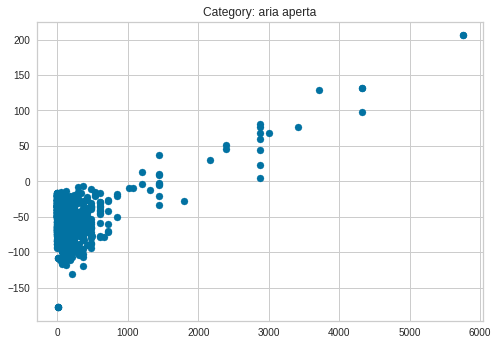

Data dimension: (792, 1624)


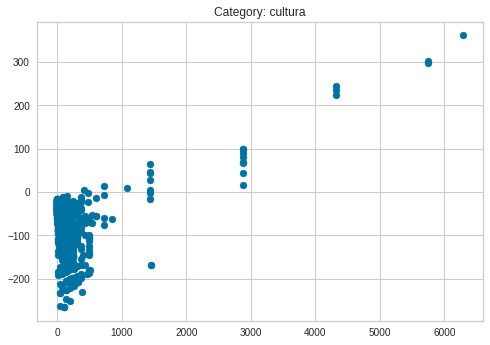

Data dimension: (1191, 2082)


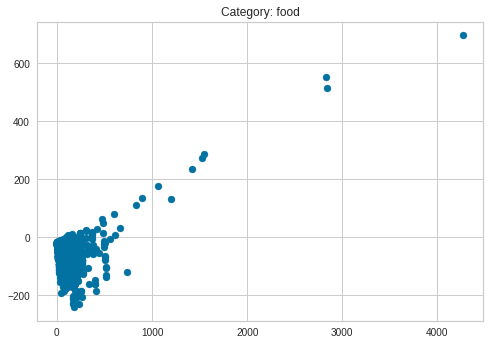

Data dimension: (326, 666)


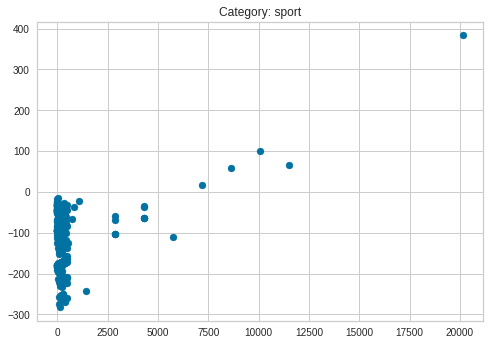

Data dimension: (522, 962)


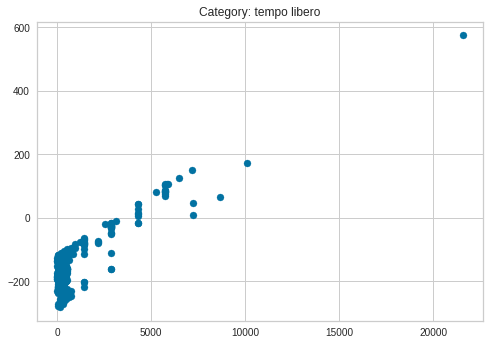

Data dimension: (934, 2119)


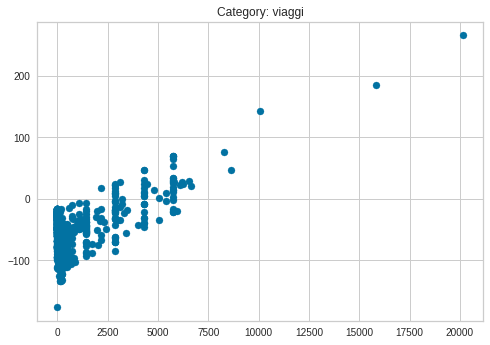

In [ ]:
svd_dict_tfidf = plot_with_SVD(X, categories, tfidf_dict)

Data dimension: (738, 770)


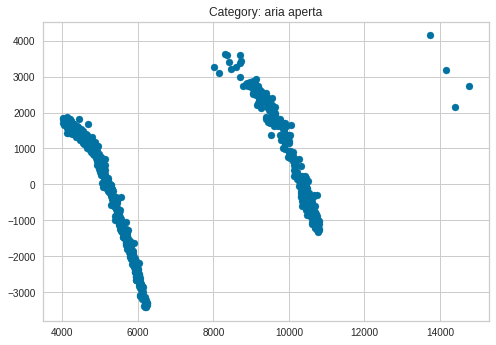

Data dimension: (792, 770)


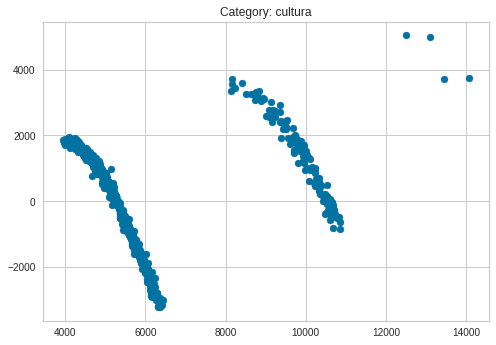

Data dimension: (1191, 770)


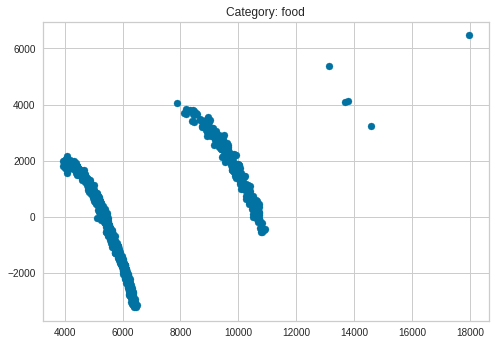

Data dimension: (326, 770)


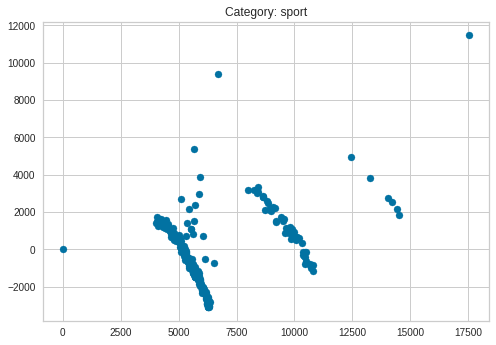

Data dimension: (522, 770)


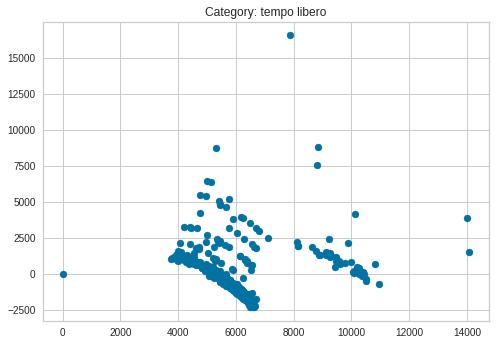

Data dimension: (934, 770)


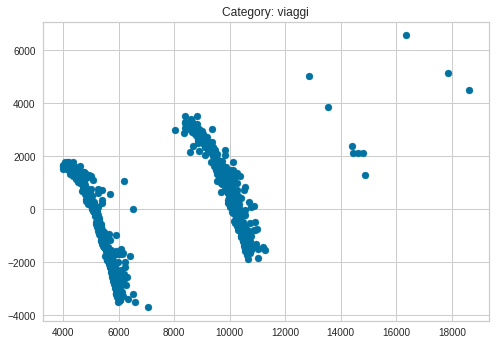

In [ ]:
svd_dict_embeddings = plot_with_SVD(X, categories, embeddings)

In [ ]:
#Plot results
def plotKMeans(label:np.ndarray, df:pd.DataFrame, category:str):
  u_labels = np.unique(label)
  for i in u_labels:
      plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
  plt.title('K-means with {} clusters for {}'.format(len(u_labels), category))
  plt.legend()
  plt.show()

In [ ]:
def kmeans_tests(data:pd.DataFrame, category:str, svd_dict:dict, clusters_number:int=10, steps:int=1):
  inertia = []
  times = dict() #{k:time_needed}
  K = range(2,clusters_number,steps) 
  for k in K:
      #Fit 
      start = time.time()
      kmeanModel = KMeans(n_clusters=k)
      kmeans = kmeanModel.fit(data)
      time_needed = time.time() - start
      times[k] = time_needed
      #Elbow
      inertia.append(kmeanModel.inertia_)
      #Clusters
      label = kmeans.predict(data)
      plotKMeans(label, svd_dict[category], category)
  return inertia, times, K

In [ ]:
def elbow_and_statistics(inertia:list, times:dict, K:list):
  #Elbow
  plt.figure(figsize=(10,3))
  plt.plot(K, inertia, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()
  print("\n")
  #Inertia
  for k,value in zip(K, inertia):
    print("Inertia for {} clusters is: {}".format(k,value))
  print("\n")
  #Times needed
  for k,v in times.items():
    print("Time needed to fit kmeans with {} clusters is: {}".format(k,v))

In [ ]:
def elbow_visualizer(data:pd.DataFrame, k:int):
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=k)
  visualizer.fit(data)        
  visualizer.show() 

In [ ]:
def kmeans_computation(data:pd.DataFrame, description_dict:dict, categories:list, svd:dict, k:int, visualizer:bool=False):
  assert type(categories)==list, "Expected list as input not {}".format(type(categories))
  for c in categories:
    print("Category: {}".format(c))
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    if visualizer:
      #kmeans
      inertia, times, K = kmeans_tests(data_with_encodings, c, svd, k)
      # Elbow and inertia
      elbow_and_statistics(inertia, times, K)
    else:
      elbow_visualizer(data_with_encodings, k)  

Category: aria aperta


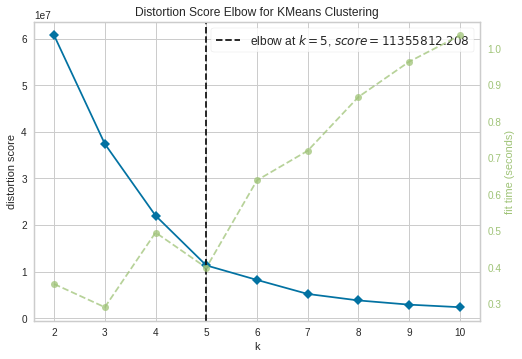

Category: cultura


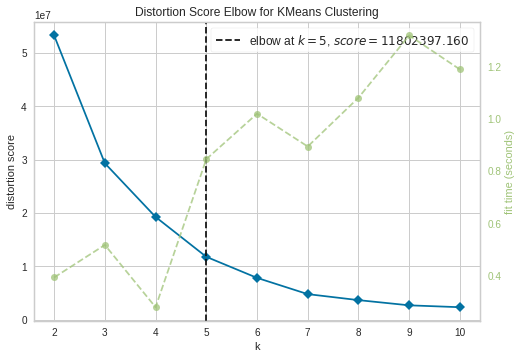

Category: food


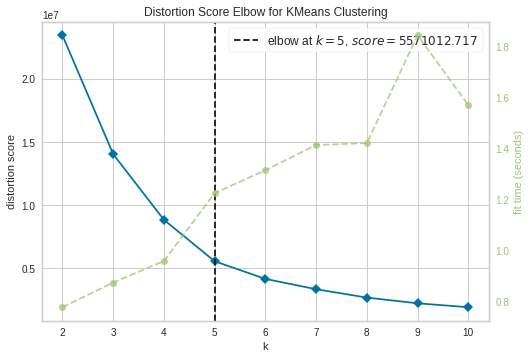

Category: sport


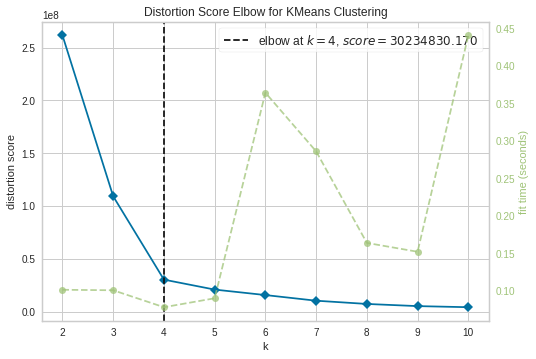

Category: tempo libero


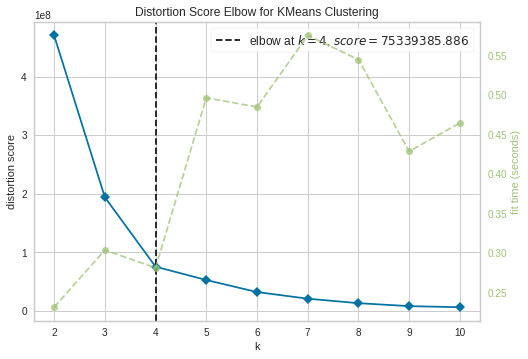

Category: viaggi


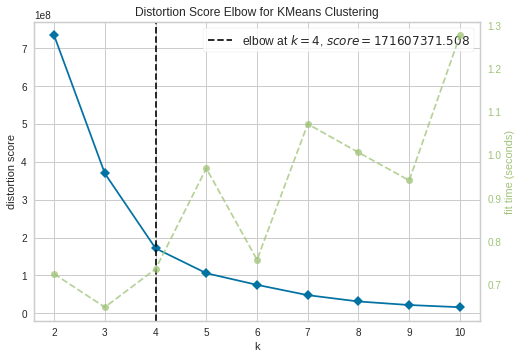

In [ ]:
kmeans_computation(X, tfidf_dict, categories, svd_dict_tfidf, 10)

Category: aria aperta


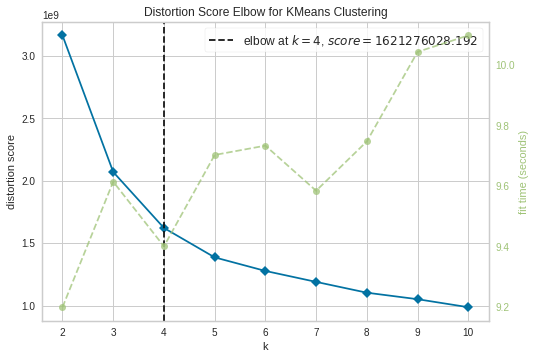

Category: cultura


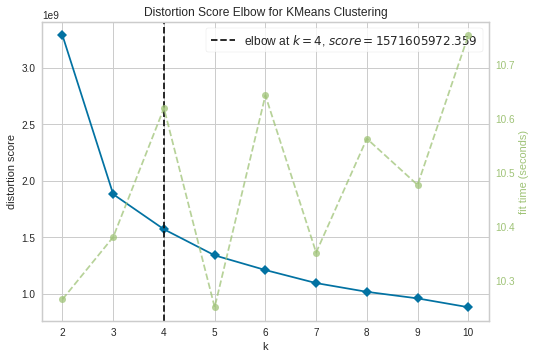

Category: food


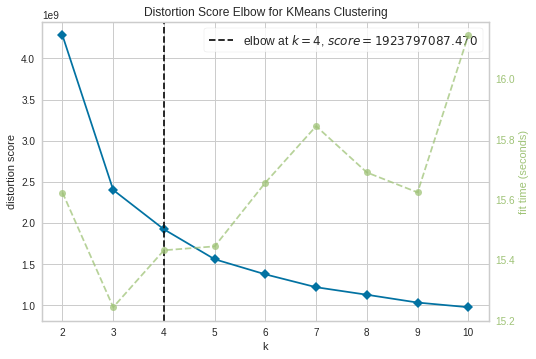

Category: sport


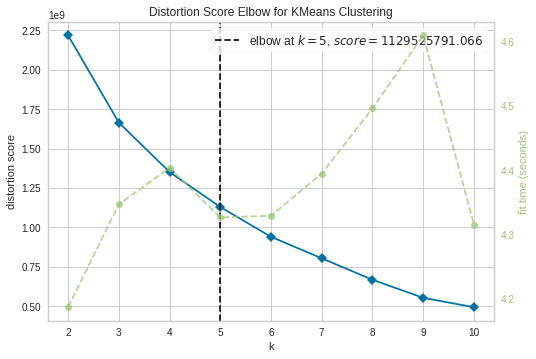

Category: tempo libero


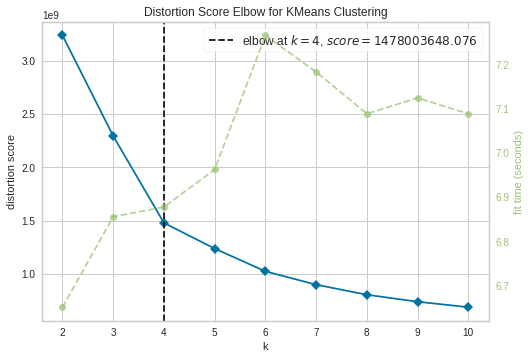

Category: viaggi


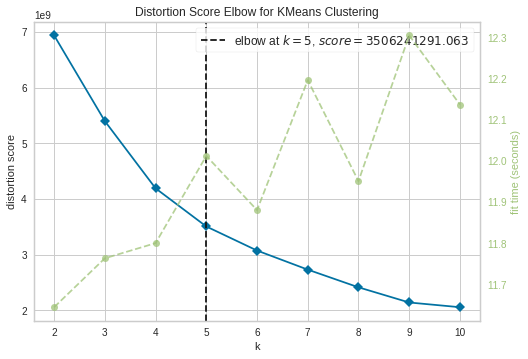

In [ ]:
kmeans_computation(X, embeddings, categories, svd_dict_embeddings, 10)

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter

In [ ]:
def plot_dbscan(data:pd.DataFrame, labels:np.ndarray, core_samples_mask:np.ndarray, n_clusters_:int):  
  unique_labels = set(labels)
  colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      if k == -1:
          # Black used for noise.
          col = [0, 0, 0, 1]

      data_array = data.to_numpy()
      class_member_mask = labels == k
      xy = data_array[class_member_mask & core_samples_mask]
      plt.plot(
          xy[:, 0],
          xy[:, 1],
          "o",
          markerfacecolor=tuple(col),
          markeredgecolor="k",
          markersize=14,
      )

      xy = data_array[class_member_mask & ~core_samples_mask]
      plt.plot(
          xy[:, 0],
          xy[:, 1],
          "o",
          markerfacecolor=tuple(col),
          markeredgecolor="k",
          markersize=6,
      )

  plt.title("Estimated number of clusters: %d" % n_clusters_)
  plt.show()

In [ ]:
def DBSCAN_categories(data:pd.DataFrame, categories:list, description_dict:dict, plot:bool=False):
  dbscan_dict = dict()
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    clustering = DBSCAN(eps=10, min_samples=10).fit(data_with_encodings)
    dbscan_dict[c] = clustering
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    counter = Counter(labels)
    counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
    print("Category '{}' has {} clusters and {} noisy points\nDistribution of the samples in the clusters: {}\n".format(c, n_clusters_, n_noise_, counter))
    if plot:
      core_samples_mask = np.zeros_like(labels, dtype=bool)
      core_samples_mask[clustering.core_sample_indices_] = True
      plot_dbscan(data_with_encodings, labels, core_samples_mask, n_clusters_)
  return dbscan_dict

Category 'aria aperta' has 9 clusters and 226 noisy points
Distribution of the samples in the clusters: {0: 232, -1: 226, 1: 71, 4: 56, 3: 43, 5: 38, 6: 19, 2: 18, 8: 18, 7: 17}



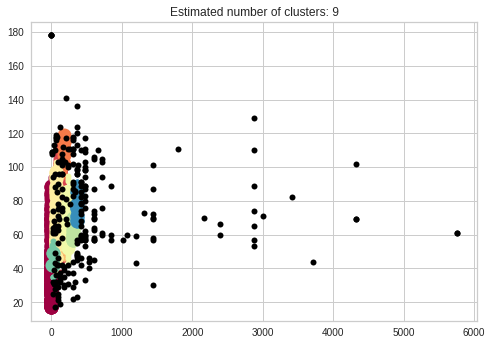

Category 'cultura' has 10 clusters and 305 noisy points
Distribution of the samples in the clusters: {-1: 305, 1: 184, 2: 128, 3: 53, 0: 32, 6: 21, 5: 17, 8: 14, 7: 13, 9: 13, 4: 12}



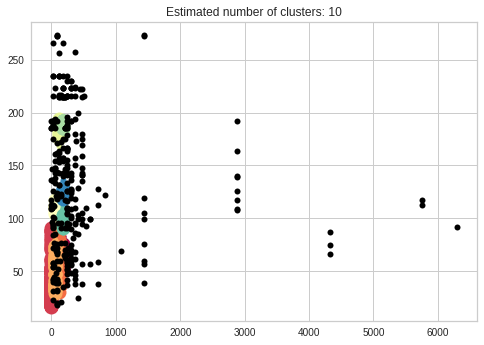

Category 'food' has 8 clusters and 234 noisy points
Distribution of the samples in the clusters: {0: 417, 1: 293, -1: 234, 4: 140, 2: 34, 3: 25, 7: 20, 5: 17, 6: 11}



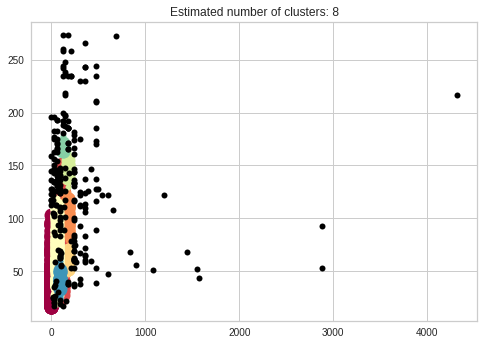

Category 'sport' has 6 clusters and 214 noisy points
Distribution of the samples in the clusters: {-1: 214, 1: 35, 5: 20, 2: 16, 0: 14, 4: 14, 3: 13}



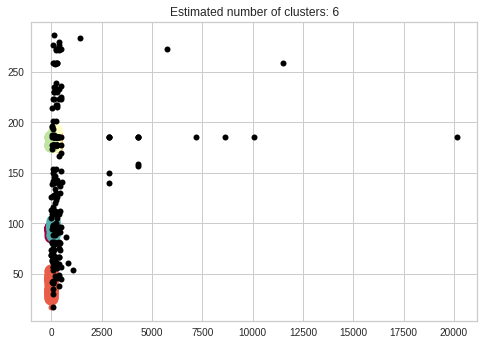

Category 'tempo libero' has 13 clusters and 297 noisy points
Distribution of the samples in the clusters: {-1: 297, 1: 32, 6: 25, 4: 24, 9: 21, 7: 21, 2: 18, 0: 15, 3: 13, 8: 13, 10: 13, 12: 10, 5: 10, 11: 10}



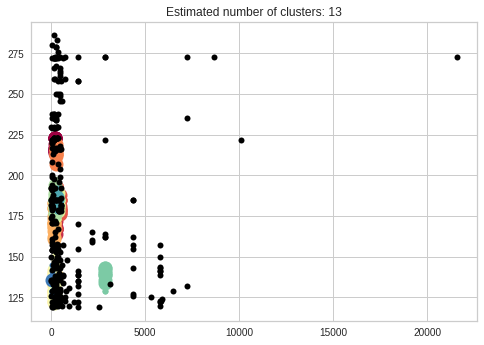

Category 'viaggi' has 12 clusters and 280 noisy points
Distribution of the samples in the clusters: {0: 382, -1: 280, 5: 50, 3: 47, 4: 35, 1: 32, 2: 28, 7: 21, 8: 20, 10: 13, 11: 12, 9: 10, 6: 4}



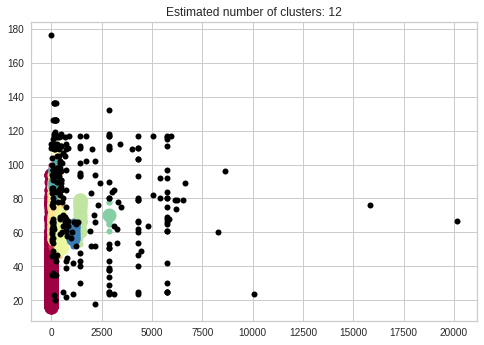

In [ ]:
dbscan_tfidf = DBSCAN_categories(X, categories, tfidf_dict, plot=True)

Category 'aria aperta' has 0 clusters and 738 noisy points
Distribution of the samples in the clusters: {-1: 738}



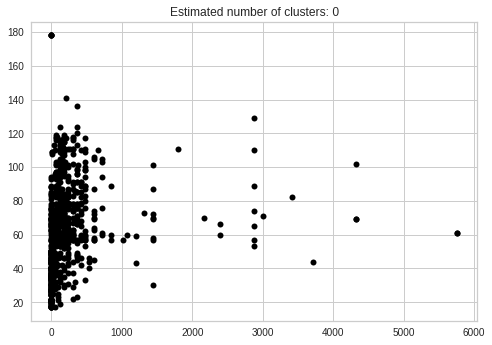

Category 'cultura' has 0 clusters and 792 noisy points
Distribution of the samples in the clusters: {-1: 792}



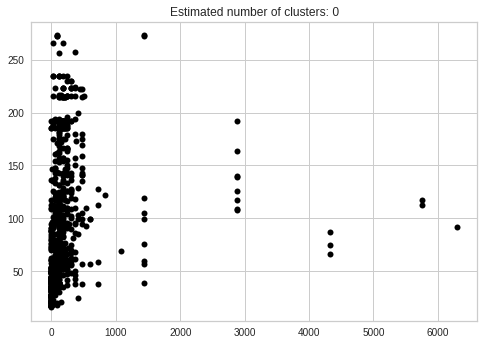

Category 'food' has 0 clusters and 1191 noisy points
Distribution of the samples in the clusters: {-1: 1191}



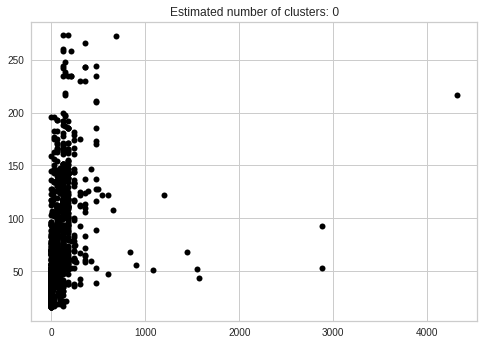

Category 'sport' has 0 clusters and 326 noisy points
Distribution of the samples in the clusters: {-1: 326}



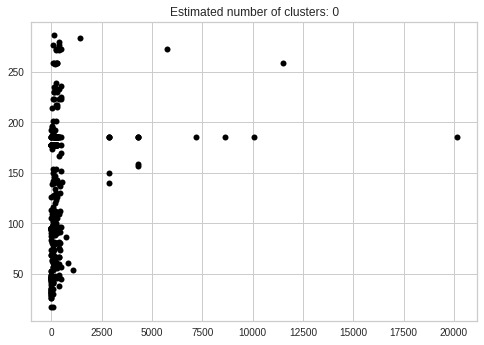

Category 'tempo libero' has 0 clusters and 522 noisy points
Distribution of the samples in the clusters: {-1: 522}



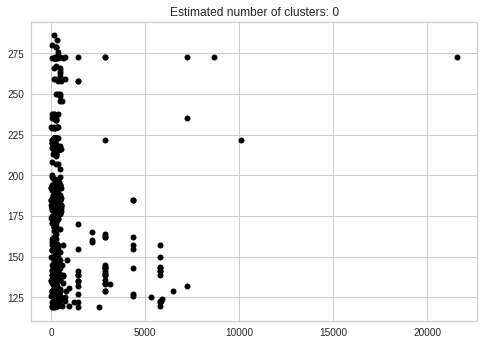

Category 'viaggi' has 0 clusters and 934 noisy points
Distribution of the samples in the clusters: {-1: 934}



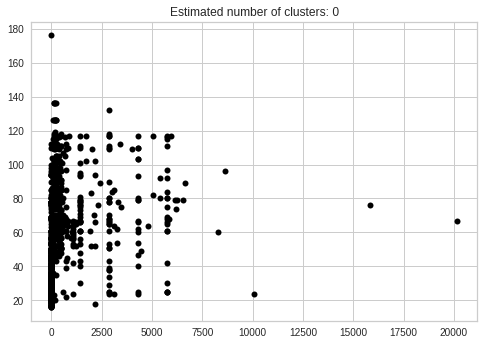

In [ ]:
dbscan_embeddings = DBSCAN_categories(X, categories, embeddings, plot=True)

### GMM

In [ ]:
def plot_GMM(gmm, data:pd.DataFrame):
  data_array = data.to_numpy()
  gmm_labels = gmm.predict(data_array)
  plt.scatter(data_array[:,0], data_array[:,1], c=gmm_labels, cmap='rainbow')
  plt.axis('equal')
  plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture

def GMM_categories(data:pd.DataFrame, categories:list, description_dict:dict, plot:bool=False):
  gmm_dict = dict()
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    gmm = GaussianMixture(n_components=5, random_state=42).fit(data_with_encodings)
    gmm_dict[c] = gmm
    print("Plot of clusters for class {}".format(c))
    #plot_gmm(gmm, data_with_tfidf)
    plot_GMM(gmm, data_with_encodings)
    #plot_results(data_with_tfidf, gmm.predict(data_with_tfidf), gmm.means_, gmm.covariances_, 0, "Class {}".format(c))
  return gmm_dict

Plot of clusters for class aria aperta


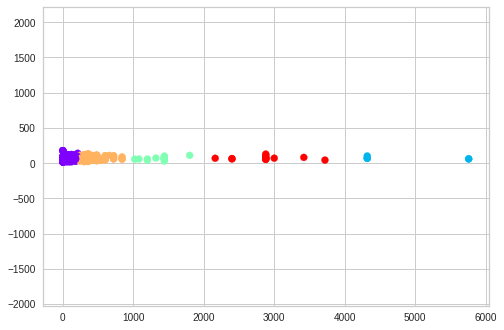

Plot of clusters for class cultura


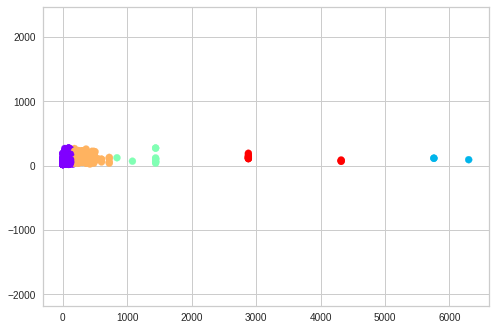

Plot of clusters for class food


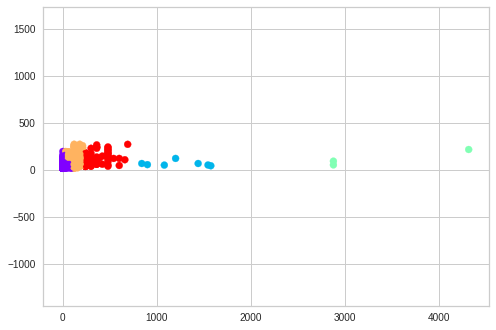

Plot of clusters for class sport


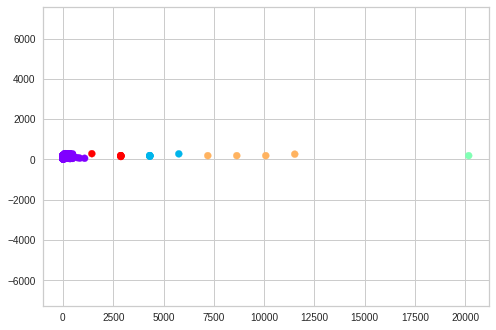

Plot of clusters for class tempo libero


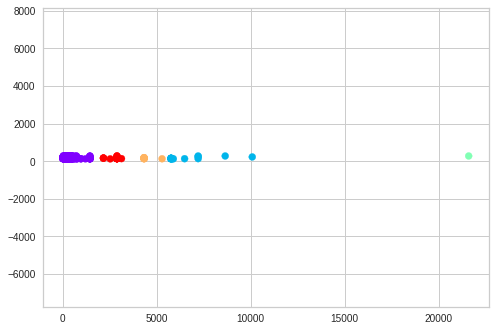

Plot of clusters for class viaggi


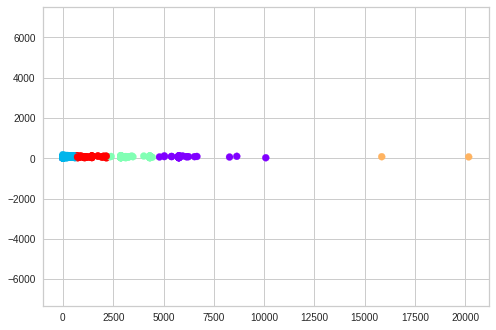

{'aria aperta': GaussianMixture(n_components=5, random_state=42),
 'cultura': GaussianMixture(n_components=5, random_state=42),
 'food': GaussianMixture(n_components=5, random_state=42),
 'sport': GaussianMixture(n_components=5, random_state=42),
 'tempo libero': GaussianMixture(n_components=5, random_state=42),
 'viaggi': GaussianMixture(n_components=5, random_state=42)}

In [ ]:
GMM_categories(X, categories, tfidf_dict, plot=True)

Plot of clusters for class aria aperta


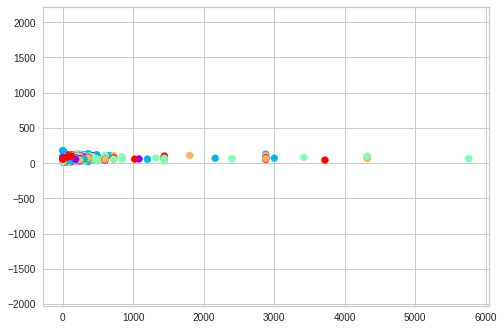

Plot of clusters for class cultura


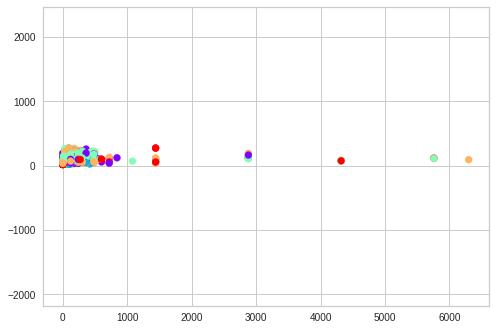

Plot of clusters for class food


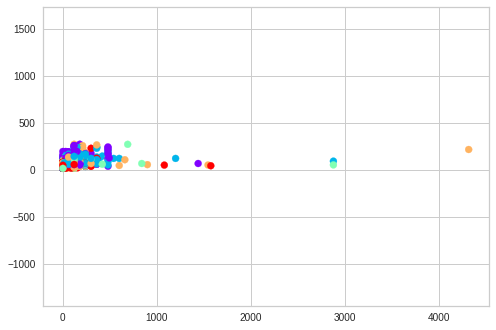

Plot of clusters for class sport


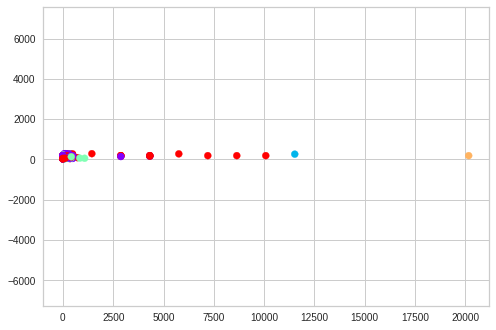

Plot of clusters for class tempo libero


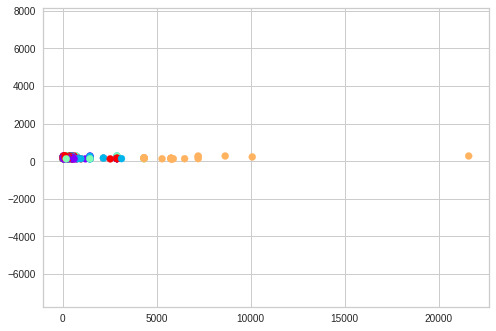

Plot of clusters for class viaggi


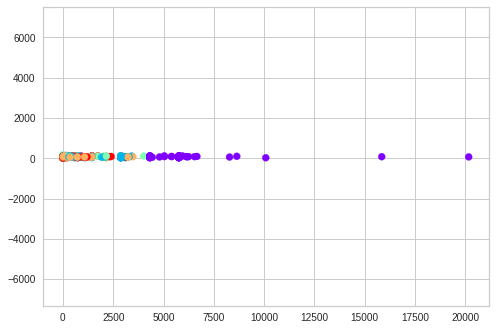

{'aria aperta': GaussianMixture(n_components=5, random_state=42),
 'cultura': GaussianMixture(n_components=5, random_state=42),
 'food': GaussianMixture(n_components=5, random_state=42),
 'sport': GaussianMixture(n_components=5, random_state=42),
 'tempo libero': GaussianMixture(n_components=5, random_state=42),
 'viaggi': GaussianMixture(n_components=5, random_state=42)}

In [ ]:
GMM_categories(X, categories, embeddings, plot=True)

### UMAP + HDBSCAN

In [ ]:
!pip install hdbscan
!pip install umap-learn

     |████████████████████████████████| 5.2 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330787 sha256=010db4b98d2b557b23e88da6dd9538284c3f303b10bdcfb3df61c01cec92f61e
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 24.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0ba5e1975819b8965bc27a047c1e35909cef1d06ccba3625ccbb7f658975cbee
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=8d08e0bea4cd18411c6dfa8ec2438f1a333ce7d857e

In [ ]:
import hdbscan
import umap.umap_ as umap

In [ ]:
def plot_clusters(embeddings, clusters, n_neighbors:int=15, min_dist:float=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

In [ ]:
def score_clusters(clusters, prob_threshold:float = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [ ]:
def generate_clusters(message_embeddings,
                      n_neighbors:int,
                      n_components:int, 
                      min_cluster_size:int,
                      min_dist:float,
                      min_samples:int = None,
                      random_state:int = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                #metric = 'cosine', 
                                min_dist = min_dist,
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               #metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    return clusters

In [ ]:
def compute_hdbscan_dict(embeddings:dict, 
                         categories:list, 
                         n_neighbors:int = 100, 
                         n_components:int = 2, 
                         min_cluster_size:int = 100,
                         min_dist:float = 0.5): 

  hdbscan_clusters = dict()
  for c in categories:
    print("Clustering category '{}'".format(c))
    try:
      if type(embeddings[c]) == list:
        embeddings_cpu = torch.Tensor(len(embeddings[c]), len(embeddings[c][0]))
        list_emb = [t.unsqueeze(0) for t in embeddings[c]] 
        #print(embeddings_cpu.shape, list_emb[0].shape)
        embeddings_cpu = torch.cat(list_emb, dim=0)
        encodings = embeddings_cpu.cpu()
        #print(embeddings_cpu.device)
      else:
        encodings = embeddings[c]
      hdbscan_clusters[c] = generate_clusters(encodings,
                                              n_neighbors = n_neighbors, 
                                              n_components = n_components, 
                                              min_cluster_size = min_cluster_size,
                                              min_dist = min_dist,
                                              random_state=42)
      labels_def, cost_def = score_clusters(hdbscan_clusters[c])
      print("Number of labels: {}".format(labels_def))
      print("Cost: {}".format(cost_def))
      plot_clusters(encodings,
                    hdbscan_clusters[c],
                    n_neighbors = n_neighbors,
                    min_dist = min_dist)
    except Exception as e:
      print("---> Cannot cluster category '{}' because of error:\n{}".format(c, e))
      #continue
    print()
  return hdbscan_clusters

Clustering category 'aria aperta'
Number of labels: 2
Cost: 0.0


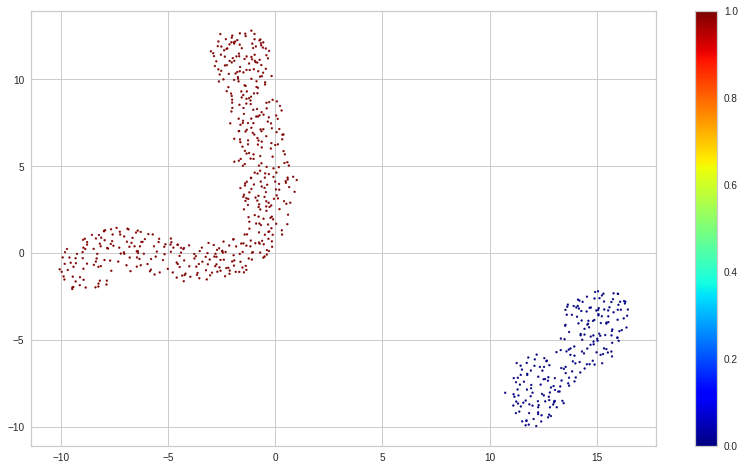


Clustering category 'cultura'
Number of labels: 2
Cost: 0.0


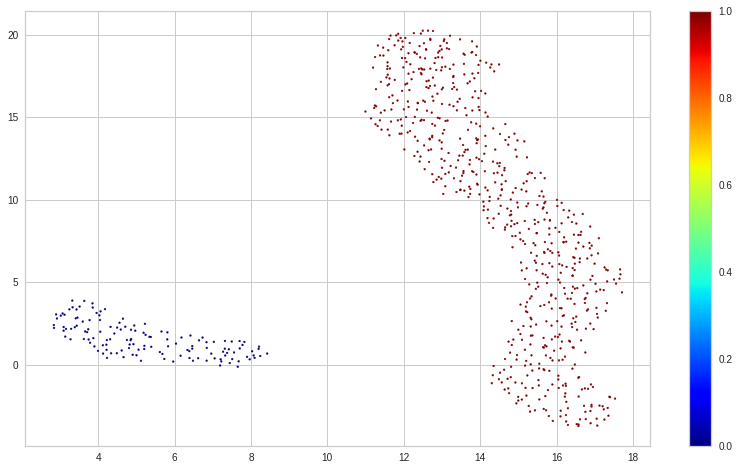


Clustering category 'food'
Number of labels: 2
Cost: 0.0


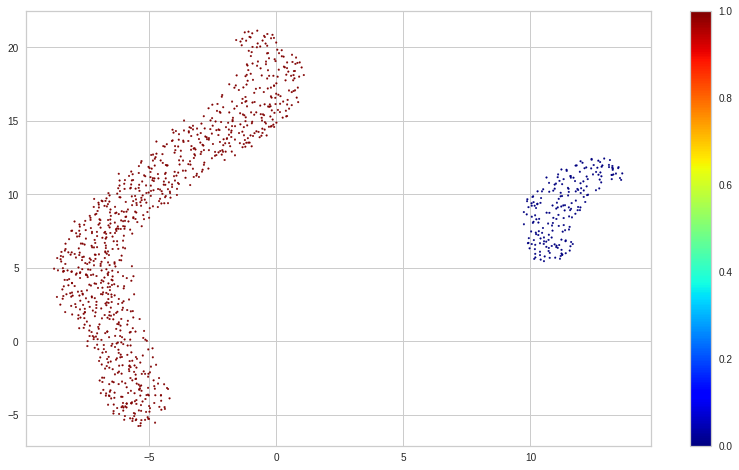


Clustering category 'sport'
Number of labels: 2
Cost: 0.0


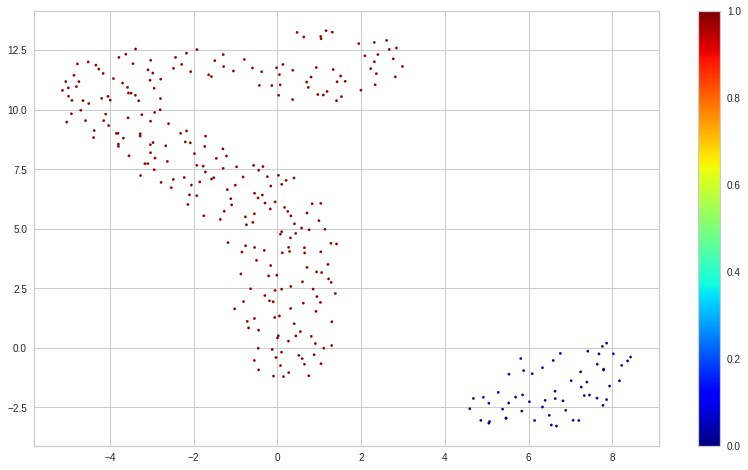


Clustering category 'tempo libero'
Number of labels: 2
Cost: 0.0


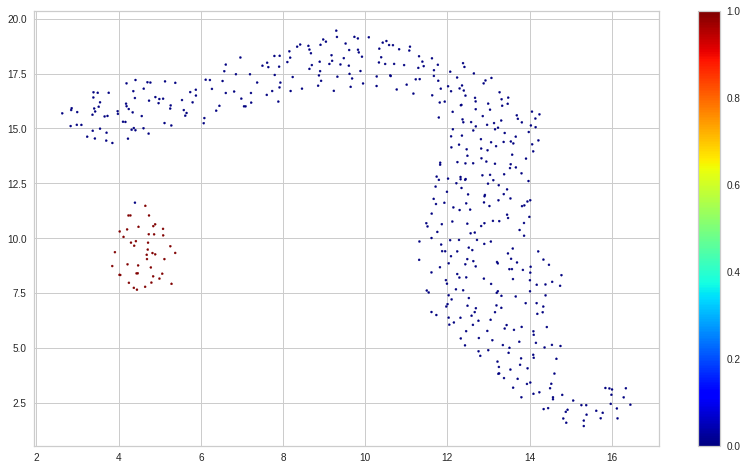


Clustering category 'viaggi'
Number of labels: 2
Cost: 0.0


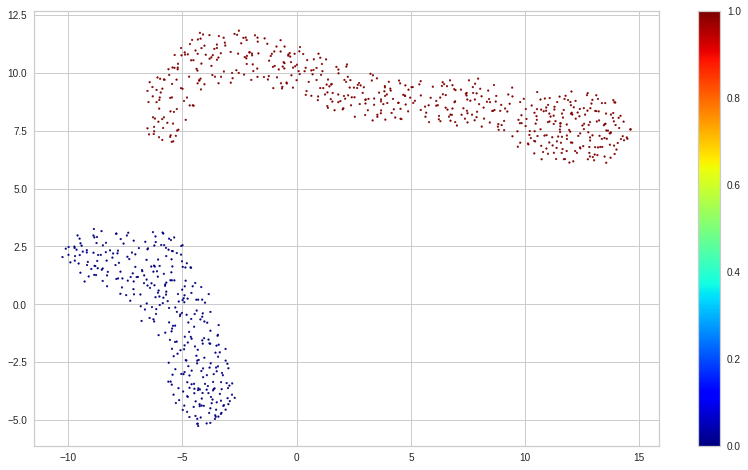

In [ ]:
hdbscan_dict = compute_hdbscan_dict(embeddings, 
                                    categories,
                                    n_neighbors = 200, 
                                    n_components = 2, 
                                    min_cluster_size = 30,
                                    min_dist=0.9)

Clustering category 'aria aperta'
Number of labels: 3
Cost: 0.2506775067750677


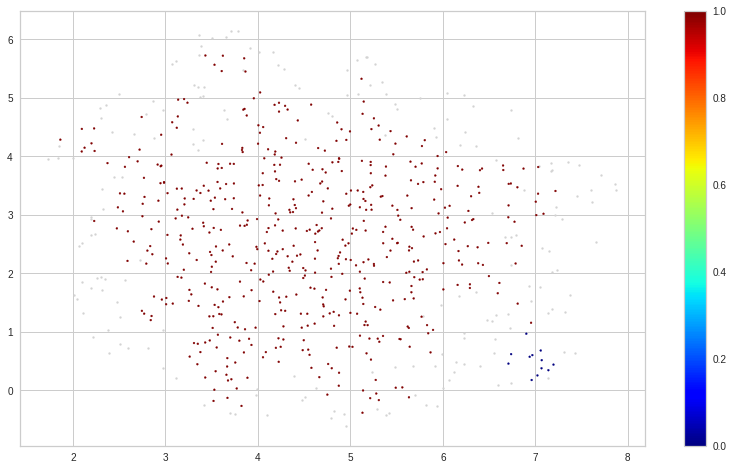


Clustering category 'cultura'
Number of labels: 3
Cost: 0.06060606060606061


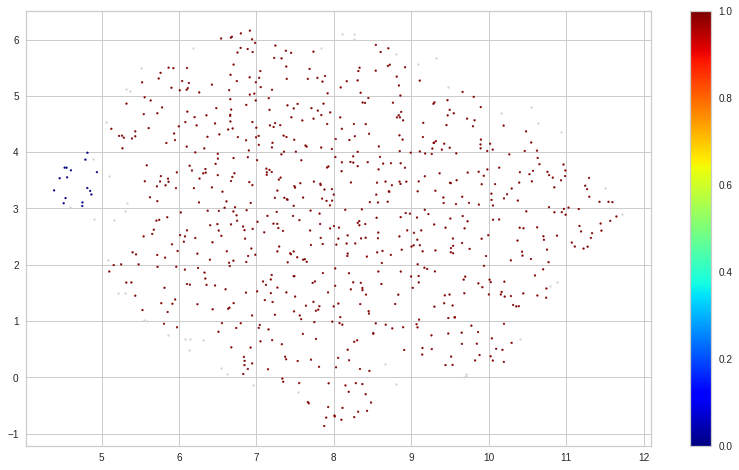


Clustering category 'food'
Number of labels: 2
Cost: 0.0


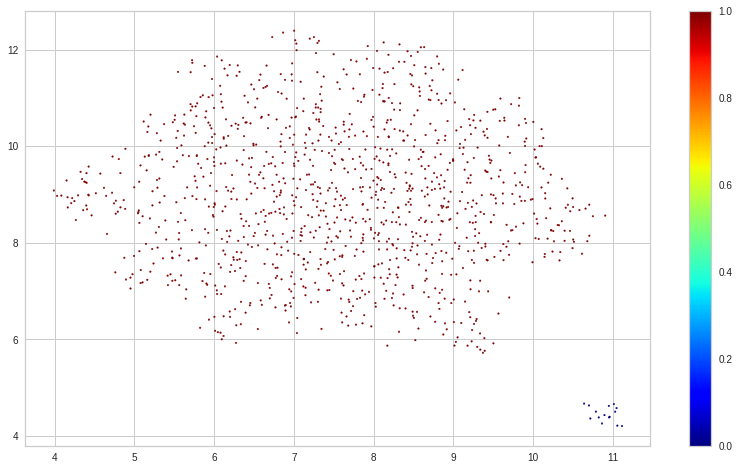


Clustering category 'sport'
Number of labels: 4
Cost: 0.8190184049079755


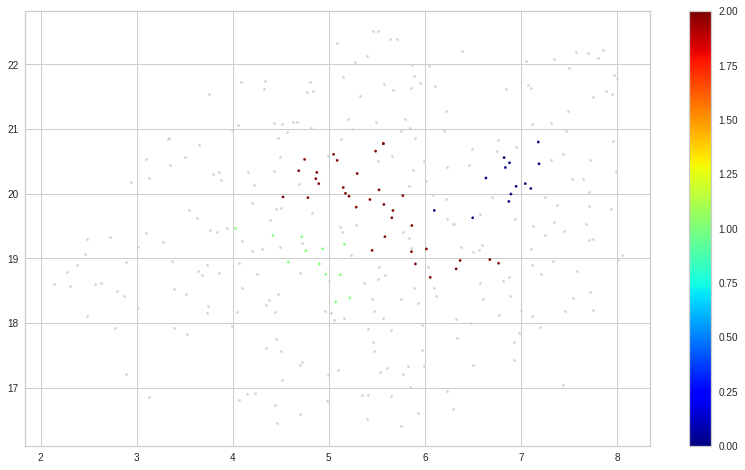


Clustering category 'tempo libero'
Number of labels: 3
Cost: 0.10727969348659004


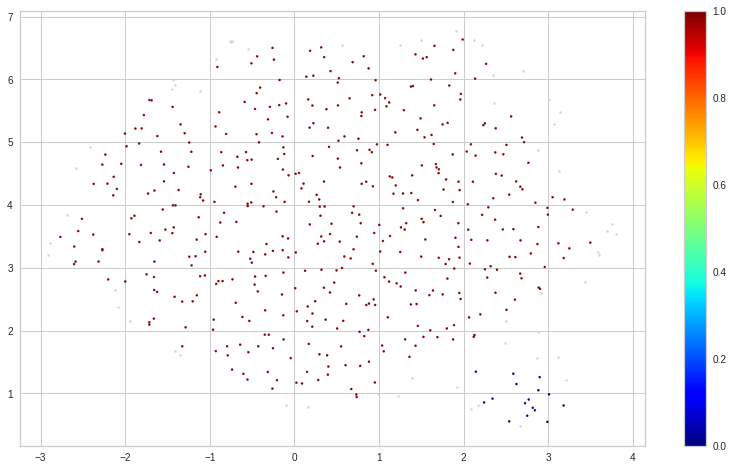


Clustering category 'viaggi'
Number of labels: 3
Cost: 0.14882226980728053


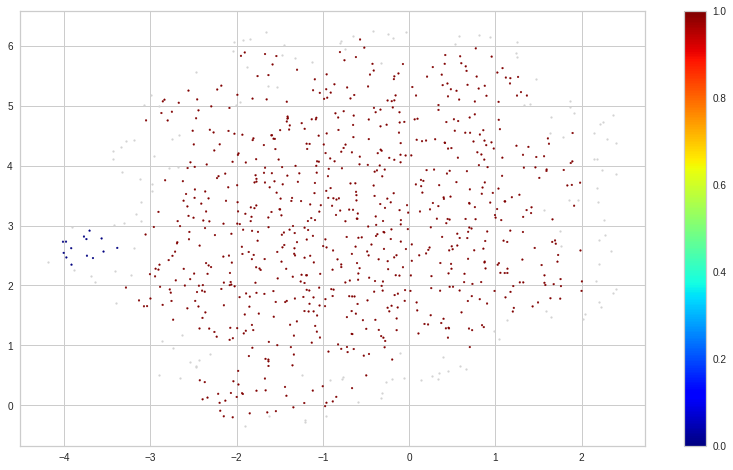

In [ ]:
hdbscan_dict = compute_hdbscan_dict(tfidf_dict,
                                    categories,
                                    n_neighbors = 100, 
                                    n_components = 2, 
                                    min_cluster_size = 10,
                                    min_dist=0.5)

### WEClustering

The algorithm is described in my notes (/Clustering/WECustering)

#### Phases 1-2: Preprocess, embeddings extraction and filtration

In [20]:
!pip install emoji

     |████████████████████████████████| 175 kB 9.6 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=bf69b5961f6ddd20a934f4bbbe8ddfadf22d8d274498fdfa40733f2461557a50
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [21]:
from math import ceil
from tqdm import tqdm

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')
ita_stopwords = set(nltk.corpus.stopwords.words('italian'))

import emoji
import string
punctuation = string.punctuation.replace("#","")
punctuation += '’'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
device = 0
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [27]:
class MyTransformer():
    def __init__(
            self,
            pretrained_model_name_or_path: str = "dbmdz/bert-base-italian-cased",
            device: str = 'cpu'
    ):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        self.model = AutoModel.from_pretrained(pretrained_model_name_or_path)
        self.model.to(device)
        print("Device used: {}".format(self.model.device))
        self.word_dictionary = dict()
        self.set_w = set()

    def add_special_tokens(self, tokens_ids):
      # add CLS (token_id is 101) and SEP (token_id is 102)
      ids = [101] + tokens_ids + [102]
      # add padding (token_id is 0)
      padding_length = 512-len(ids)
      for i in range(padding_length):
        ids += [0]
      #print("\n padding_length: {} - len(tokens_ids): {}\nTokens_ids: {}".format(padding_length, len(ids), ids))
      return ids

    def compute_embedding(self, tokens_ids):
      self.model.eval()
      with torch.no_grad():
        if(len(tokens_ids) <= 510):
          #tokens_ids = self.add_special_tokens(tokens_ids)
          context_embeddings = self.model(torch.tensor(tokens_ids)[None,:].to(device))[0]
        else:
          k = ceil(len(tokens_ids) / 510.0)
          chunks = np.array_split(tokens_ids, k)
          for i in range(len(chunks)):
            chunks[i] = self.add_special_tokens(chunks[i].tolist())
          chunks_tensor = torch.tensor(chunks[0])[None,:].to(device)
          context_embeddings_list = self.model(chunks_tensor)[0].to(device)
          for i in range(1, len(chunks)):
            chunks_tensor = torch.tensor(chunks[i])[None,:].to(device)
            context_embeddings_list = torch.cat((context_embeddings_list, self.model(chunks_tensor)[0]), 1)
          #dim = context_embeddings_list.shape[-1]
          context_embeddings = context_embeddings_list.to(device)
        #compute the average of the vectors
        #avg_embeddings = torch.sum(context_embeddings,1)[0]
        #print("Embeddings shape: {}".format(context_embeddings.shape))
      return context_embeddings

    def demoji(self, text):
      allchars = [str for str in text] #.decode('utf-8')
      emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
      clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
      return clean_text


# I can obtain the embedding of a word by averaging the subwords -> 
# once I have the sentence's embeddings I can transform subwords back to words 
# ## means that the subword has to be attached to the previous one without spaces

    def words_from_subwords(self, emb, tokens:list):
      list_emb = emb.tolist()
      res_tokens = []
      res_emb = []
      for j, t in enumerate(tokens):
        if t[:2] == "##":
          #print(tokens[j-1], tokens[j])
          word = res_tokens[-1] + tokens[j].replace("#", "")
          res_tokens[-1] = word
          emb_mean = [np.mean(k) for k in zip(res_emb[-1], list_emb[0][j])]
          res_emb[-1] = emb_mean
        else:
          res_tokens.append(t)
          res_emb.append(list_emb[0][j])
      return torch.unsqueeze(torch.Tensor(res_emb), 0), res_tokens

    def filter_embeddings(self, emb, tokens:list):
      list_emb = emb.tolist()
      res_tokens = []
      #print(len(list_emb[0]))
      del_count = 0
      for j, t in enumerate(tokens):
        #remove [UNK]
        if t == "[UNK]":
          list_emb[0].pop(j-del_count)
          del_count += 1
        #remove digits
        elif any(ch.isdigit() for ch in t):
          list_emb[0].pop(j-del_count)
          del_count += 1
        #remove punctuation
        elif any(ch in punctuation for ch in t):
          list_emb[0].pop(j-del_count)
          del_count += 1
        #remove stopwords
        elif t.lower() in ita_stopwords: #.replace("#", "")
          list_emb[0].pop(j-del_count)
          del_count += 1
        else:
          res_tokens.append(t)
      return torch.Tensor(list_emb), res_tokens

    def compute_word_dictionary(self, tokens:list, embeddings:list, doc:int):
      for t,e in zip(tokens, embeddings[0]):
        #print("TOKEN: " + t)
        #print("emb shape: {}".format(e.shape))
        if t in self.word_dictionary:
          # add doc -> if a token appears more than once in a document than it will be added multiple times
          self.word_dictionary[t][1].append(doc)
          #print("DICT: {}".format(self.word_dictionary[t]))
          # compute new value for the embeddings of the token
          numb_doc = len(self.word_dictionary[t][1])
          #old_emb = torch.mul(self.word_dictionary[t][0], numb_doc-1) 
          old_emb = self.word_dictionary[t][0]
          assert not True in torch.isinf(old_emb), "Bug in torch.mul: {}".format(torch.isinf(old_emb))
          list_old_emb = [old_emb for i in range(numb_doc-1)]
          #print(len(list_old_emb), numb_doc)
          list_old_emb.append(e)
          new_emb = torch.stack(list_old_emb, dim=0)
          assert not True in torch.isinf(new_emb), "Bug in new_emb: {}".format(new_emb)
          #print("SHAPE: {}".format(new_emb.shape))
          mean = torch.mean(new_emb, dim=0)
          assert not True in torch.isinf(mean), "Bug in torch.mean: {} {} {} {} {}".format(numb_doc, e, self.word_dictionary[t][0], new_emb, mean)
          self.word_dictionary[t][0] = mean
          #print(self.word_dictionary[t][0].shape, self.word_dictionary[t][1])
        else:
          #print("new word")
          self.word_dictionary[t] = [e,[doc]]
          #print(self.word_dictionary[t][0].shape, self.word_dictionary[t][1])

    # check if number of distinct tokens is equal to number of tokens in the dictionary
    def nested_sum(self, L):
        total = 0 
        for i in L:
            if isinstance(i, list):  # checks if `i` is a list
                self.nested_sum(i)
            else:
                self.set_w.add(i)
        return

    def check_number_words(self, tokens):
      self.nested_sum(tokens)
      assert len(self.set_w) == len(self.word_dictionary), "number of tokens in the dictionary is wrong"

    def encode(self, docs):
      embedded_docs = []
      tokens_docs = []
      for id,d in tqdm(enumerate(docs)):
        embedded_sentence = []
        tokens_sentence = []
        sentences =  nltk.tokenize.sent_tokenize(d)
        #print("-"*100)
        #print("ID: {}".format(id))
        for s in sentences:
          #s = self.demoji(s)
          if not s: #df_schede has null descriptions
            print("Empty description")
            empty_embedding = torch.zeros(768).to(device)
            embedded_sentence.append(empty_embedding)
            tokens_sentence.append([])
            continue
          t = self.tokenizer.tokenize(s)
          tokens_ids = self.tokenizer.convert_tokens_to_ids(t)
          #print("Tokens: {}".format(t))
          #print("Number of tokens ids: {}".format(len(tokens_ids)))
          embedding = self.compute_embedding(tokens_ids)
          #print("DIM after compute_embedding: {} {}".format(embedding.shape, len(tokens_ids)))
          #print(t)
          words_emb, words_tokens = self.words_from_subwords(embedding, t)
          #print("DIM after merging of the subwords: {} {}".format(words_emb.shape, len(words_tokens)))
          filtered_emb, filtered_tokens = self.filter_embeddings(words_emb, words_tokens)
          #print("DIM after filter: {} {}".format(filtered_emb.shape, len(filtered_tokens)))
          self.compute_word_dictionary(filtered_tokens, filtered_emb, id)
          embedded_sentence.append(filtered_emb)
          tokens_sentence.append(filtered_tokens)
          #print("After filter: {}".format(filtered_emb.shape))
        embedded_docs.append(embedded_sentence)
        tokens_docs.append(tokens_sentence)
      self.check_number_words(tokens_docs)
      return embedded_docs, tokens_docs

In [28]:
model = MyTransformer(device=device)
#embeddings, tokens = model.encode(df_schede.description)
embeddings, tokens = model.encode(df_schede.description.iloc[:100])

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device used: cuda:0


100it [01:11,  1.39it/s]


In [29]:
#a = torch.Tensor(embeddings)
count = 0
for e in model.word_dictionary.values():
  if True in torch.isinf(e[0]):
    count += 1
    #print(e[0])
    print("Infinite")
print(count)

0


#### Save results in files

In [ ]:
embeddings_path = "/content/drive/MyDrive/Tesi/WEClustering.pt"
tokens_path = "/content/drive/MyDrive/Tesi/WEClustering_tokens.csv"
word_dictionary_path = "/content/drive/MyDrive/Tesi/words.pkl"

In [ ]:
# import pickle
# w_file = open(word_dictionary_path, "wb")
# pickle.dump(model.word_dictionary, w_file)
# w_file.close()

# w_file = open(word_dictionary_path, "rb")
# output = pickle.load(w_file)
# print(output)

In [ ]:
# import csv
# # save embeddings
# torch.save(embeddings, embeddings_path)
# # save tokens
# with open(tokens_path, "w") as f:
#     wr = csv.writer(f)
#     wr.writerows(tokens)

In [ ]:
# import csv
# # load embeddings
# embeddings = torch.load(embeddings_path)
# # load tokens
# with open(tokens_path, 'r') as read_obj:
#     csv_reader = csv.reader(read_obj)
#     tokens = list(csv_reader)
#     #print(tokens)

#### TF-IDF

In [30]:
import ast
# from list of lists to list of documents
docs = []
for d in tokens:
  doc = []
  for s in d:
    if type(s)==str:
      doc += ast.literal_eval(s)
    else:
      doc += s
  text = " ".join(doc)
  docs.append(text)

In [31]:
tfidf_vectorizer = TfidfVectorizer(lowercase=False)

#text = data.description
tfidf_schede = tfidf_vectorizer.fit_transform(docs)
dense_text = tfidf_schede.todense()
denselist_text = dense_text.tolist()

dataset_text_tfidf = pd.DataFrame(denselist_text, index=df_schede.description.iloc[:len(tokens)].index,
                                  columns=tfidf_vectorizer.get_feature_names())
dataset_text_tfidf

,AJC,ATM,Above,Abul,Acquistare,Adhai,Affacciandosi,Afghanistan,Africa,Aggirandosi,...,zampe,zangolando,zenzero,zipline,zona,zone,zoo,zucca,zuccherato,zucchero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.048885,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.036285,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.077819,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.041149,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.043196,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.120413,0.000000,0.000000,0.0,0.0,0.0,0.0


In [32]:
np.count_nonzero(dataset_text_tfidf)

16353

#### Phase 3: Clustering of word embeddings

Build a matrix of dimension (n_words*768) and use K-means on it. How to build this matrix (not specified in the paper)?

1.   Take average of a certain token occurrences;
2.   Consider all the embeddings as separated words

I am using the first approach

In [33]:
embs_list = list()
words_array = list()
for k,v in model.word_dictionary.items():
  words_array.append(k)
  embs_list.append(v[0].cpu().detach().numpy())

embs_array = np.array(embs_list)

In [34]:
embs_array.shape

(7195, 768)

In [39]:
from sklearn.cluster import MiniBatchKMeans
def compute_mini_kmeans(data_array):
  mini_kmeans = KMeans()
  #mini_kmeans = MiniBatchKMeans(random_state=0)#,batch_size=64)
  visualizer = KElbowVisualizer(mini_kmeans, k=range(4,30,2), timings=False)

  visualizer.fit(data_array)        
  visualizer.show() 
  elbow = visualizer.elbow_value_
  #cluster with optimal number of clusters
  clustering = KMeans(n_clusters=elbow, random_state=0).fit(embs_array)
  labels = clustering.labels_

  return labels, elbow

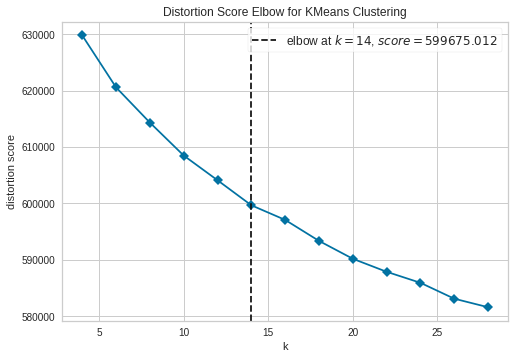

In [40]:
labels, elbow = compute_mini_kmeans(embs_array)

In [41]:
np.unique(labels, return_counts=True) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       dtype=int32),
 array([606, 211, 566, 647, 404, 269, 544, 504, 389, 671, 510, 556, 573,
        745]))

#### Phase 4: Generation of concept-document matrix CD


In [42]:
labels

array([11, 10,  7, ...,  4,  4, 10], dtype=int32)

In [43]:
print(len(dataset_text_tfidf.columns), len(words_array), len(labels))

7178 7195 7195


In [44]:
CD_list = [[] for i in range(len(tokens))]
for c in range(elbow):
  #retrieve tokens in concept
  tokens_index = np.where(labels == c)
  tokens_in_c = []
  for idx in tokens_index[0]:
    tokens_in_c.append(words_array[idx])
  for d in range(len(tokens)):
    #retrieve TF-IDF for the words
    val = 0
    for t in tokens_in_c:
      try:
        val += dataset_text_tfidf[t].iloc[d]
      except:
        continue
    CD_list[d].append(val)

In [45]:
CD_matrix = np.array(CD_list)

In [46]:
CD_matrix.shape

(100, 14)

#### Phase 5: Clustering of the CD matrix

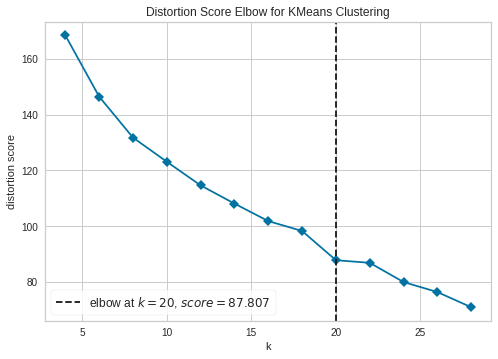

In [47]:
final_labels, final_elbow = compute_mini_kmeans(CD_matrix)

### LDA

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 3.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=bde71bdbf5e050b84d31addfa8691e7b07f40e73685b848c3f40d69aa0cc6744
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
import os
import ast

In [ ]:
texts = list(data.description)
for i,t in enumerate(texts):
  texts[i]= ast.literal_eval(t)
id2word = gensim.corpora.Dictionary(texts)
corpus = [id2word.doc2bow(t) for t in texts]

In [ ]:
# number of topics
num_topics = 30
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
import pyLDAvis.gensim_models
import pyLDAvis
# Visualize the topics
#pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
pyLDAvis.display(LDAvis_prepared)

### Top2Vec

In [ ]:
!pip install top2vec

     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from top2vec import Top2Vec

In [ ]:
model = Top2Vec(documents=list(df_schede.description), speed="learn")

2022-05-10 08:30:26,627 - top2vec - INFO - Pre-processing documents for training
2022-05-10 08:30:32,848 - top2vec - INFO - Creating joint document/word embedding
2022-05-10 08:32:41,462 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-10 08:32:54,170 - top2vec - INFO - Finding dense areas of documents
2022-05-10 08:32:54,286 - top2vec - INFO - Finding topics


In [ ]:
model.get_num_topics()

36

get_topic_sizes returns:

- topic_sizes: The number of documents most similar to each topic.

- topic_nums: The unique index of every topic will be returned.

In [ ]:
topic_sizes, topic_nums = model.get_topic_sizes()
for ts,tn in zip(topic_sizes, topic_nums):
  print("Topic {} has {} documents".format(tn,ts))

Topic 0 has 412 documents
Topic 1 has 354 documents
Topic 2 has 276 documents
Topic 3 has 256 documents
Topic 4 has 232 documents
Topic 5 has 207 documents
Topic 6 has 193 documents
Topic 7 has 188 documents
Topic 8 has 179 documents
Topic 9 has 142 documents
Topic 10 has 141 documents
Topic 11 has 139 documents
Topic 12 has 120 documents
Topic 13 has 117 documents
Topic 14 has 116 documents
Topic 15 has 112 documents
Topic 16 has 103 documents
Topic 17 has 101 documents
Topic 18 has 100 documents
Topic 19 has 99 documents
Topic 20 has 97 documents
Topic 21 has 97 documents
Topic 22 has 86 documents
Topic 23 has 84 documents
Topic 24 has 81 documents
Topic 25 has 78 documents
Topic 26 has 75 documents
Topic 27 has 72 documents
Topic 28 has 66 documents
Topic 29 has 60 documents
Topic 30 has 59 documents
Topic 31 has 48 documents
Topic 32 has 43 documents
Topic 33 has 41 documents
Topic 34 has 39 documents
Topic 35 has 34 documents


get_topics returns:

- topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.

- word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.

- topic_nums: The unique index of every topic will be returned.

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(1)
topic_words, word_scores, topic_nums

(array([['sushi', 'menu', 'cucina', 'locale', 'ristorante', 'bancone',
         'porzioni', 'antipasti', 'pietanze', 'piatti', 'personale',
         'accogliente', 'chef', 'sapori', 'cena', 'selezione', 'qualita',
         'tartare', 'cocktail', 'formula', 'ordinare', 'location',
         'tavoli', 'hamburger', 'buono', 'tavolo', 'ricette', 'manzo',
         'gentile', 'antipasto', 'pesce', 'camerieri', 'aperitivo',
         'salmone', 'clienti', 'ravioli', 'verdure', 'carne', 'baccala',
         'staff', 'curato', 'crudo', 'croccante', 'giapponese',
         'arredamento', 'proposte', 'fritti', 'pollo', 'pizze',
         'proposta']], dtype='<U14'),
 array([[0.44106054, 0.40495387, 0.36915535, 0.36807135, 0.35060945,
         0.34845954, 0.3421073 , 0.3346573 , 0.33406797, 0.33348596,
         0.32637367, 0.31952223, 0.31396103, 0.3093957 , 0.29937166,
         0.29880536, 0.29854336, 0.2972401 , 0.29428902, 0.29403824,
         0.29251742, 0.2922124 , 0.28951496, 0.2886376 , 0.288041

search_topics returns:

- topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.

- word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.

- topic_scores: For each topic the cosine similarity to the search keywords will be returned.

- topic_nums: The unique index of every topic will be returned.

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["mare"], num_topics=10)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

Output hidden; open in https://colab.research.google.com to view.

search_documents_by_topic returns:

- documents: The documents in a list, the most similar are first.

- doc_scores: Semantic similarity of document to topic. The cosine similarity of the document and topic vector.

- doc_ids: Unique ids of documents. If ids were not given, the index of document in the original corpus

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=17, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 3186, Score: 0.6957519054412842
-----------
Questa esperienza rientra sempre nella raccolta “trek&foliage”: siamo sempre in Casentino, ma questa volta nei pressi dell’eremo di Camaldoli: non passeremo proprio di lì in questo giro ma presto vi racconterò anche di quando sono riuscito a trovarlo in un mare di nebbia. Una particolarità di questa zona è che una parte della foresta è popolata da una numerosa famiglia di abeti bianchi: cosa di cui ci si può accorgere quando respirando a pieni polmoni ci si sente pervadere da un dolce aroma di resina… e in un attimo è subito Natale!
Ma torniamo a noi… di nuovo ci troviamo on the road nelle strade del casentino: un sacco di curve per la mia felicità, ma sono disposto a pagare il prezzo della lunga camminata che ci aspetta. Puntiamo il rifugio Fangacci, un piccolo rifugio immerso nel bosco, quando attivo ha una piccola foresteria ed è possibile noleggiare un po’ di attrezzatura (ciaspole, e-bike, mountain-bike): lo troviamo in fondo a

### BERTopic

In [ ]:
!pip install bertopic
!pip install distributed==2021.9.0

     |████████████████████████████████| 779 kB 37.7 MB/s 
     |████████████████████████████████| 1.0 MB 46.9 MB/s 
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: dask
    Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0
  Attempting uninstall: distributed
    Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.


In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(language="multilingual", calculate_probabilities=True)

In [ ]:
topics, probs = topic_model.fit_transform(data.description)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,2724,-1_poter_stare_roma_venir
1,0,144,0_esperienza_volo_stare_mongolfiera
2,1,117,1_small_blue_diamond_pushpin_poter_nn
3,2,89,2_periodo_weesp_poter_parco
4,3,87,3_xa0_de_poter_centro
5,4,84,4_weekend_settimana_lago_rifugio
6,5,80,5_siviglia_mare_polignano_giornata
7,6,75,6_pizza_pizzeria_napoli_fritto
8,7,67,7_museo_opera_art_collezion
9,8,67,8_lago_acqua_barca_sentiero


In [ ]:
topic_model.get_topic(25)

[('can', 0.08312039128512377),
 ('you', 0.0780602473701872),
 ('eat', 0.07059756310542123),
 ('sushi', 0.06980190602629067),
 ('mykono', 0.04087055489889072),
 ('local', 0.03606824368538193),
 ('ristorant', 0.03472484845447851),
 ('menu', 0.03370072045412545),
 ('piatto', 0.02715273485380027),
 ('cena', 0.02648050153883558)]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
similar_topics, similarity = topic_model.find_topics("sole", top_n=5); similar_topics

[1, 17, 13, 39, -1]

In [ ]:
topic_model.get_topic(17)

[('rifugio', 0.04068983300671325),
 ('sentiero', 0.029776078273584687),
 ('alp', 0.02807951539810163),
 ('mont', 0.027352116577563396),
 ('betulla', 0.02028776907054939),
 ('provincia', 0.020046068874982125),
 ('rocca', 0.018967585153537938),
 ('vall', 0.018440465462326402),
 ('montagna', 0.017743085771155697),
 ('alpeggio', 0.01750995147938956)]

### RS

We first compute two lists of recommended users (i.e. the users with smallest distance), one based on similarity on schede posted by user and the other on likes. From this lists we obtain two ranked lists of schede that are merged.


The distance between two user is computed in the following way: 

1.   for each category, the distance between two users is computed as the sum of the differences in numbers of posts in each cluster weighted by the ranking of each cluster in the category (a cluster with less posts weights more, i.e. $∑_{c=1}^r \frac{d[c]}{\log_2(rank(c)+1)}$) and by the total number of posts of the two users;
2.   the total distance is computed using the following formula: distance = $∑_{c=1}^r \frac{d[c]}{\log_2(rank(c)+1)}$, where d is a list of distances per category computed in the previous step and rank(c) is the ranking of the category c for the target user (the ranking depends on the number of posts, i.e. the first post in the ranking is the category that has the highest number of posts)

Once we have the lists of recommended users we want to choose the most suited posts for the target from them. We can do this in two ways:
1.   Consider posts that most similar users liked
2.   Consider posts with more likes

The first method will be used on the list of recommended users based on likes, the second method for the lists obtain using similarity on posted schede. In more details:

1.   Get the posts that most similar users liked and rank them considering the number of likes, weighted by importance of who liked the posts (likes from users that are in the recommendation lists are more important);
2.   Get the posts from the most similar users and rank them considering the number of likes, weighted by importance of who liked the posts (likes from users that are in the recommendation lists are more important).

Finally, I just merge the two ranked lists using the scores obtain in the previous step.

In [ ]:
optimal_number_clusters = {"aria aperta":4, "cultura":4, "food":4, "sport":3, "tempo libero":3, "viaggi":5}
#optimal_number_clusters = {"aria aperta":7, "cultura":7, "food":7, "sport":7, "tempo libero":7, "viaggi":7}
#optimal_number_clusters = {"aria aperta":10, "cultura":10, "food":10, "sport":10, "tempo libero":10, "viaggi":10}

In [ ]:
# Return list of ranking for clusters ordered in ascending manner by number of posts
# the list has in i-th position the ranking of the i-th cluster 
def rank_clusters_in_categories(counts:pd.DataFrame, 
                                category:str):
  counts.sort_values(inplace=True)
  ordered_clusters = [x[0] for x in counts.index]
  ranking = [0 for x in ordered_clusters]
  for idx, r in enumerate(ordered_clusters):
    ranking[r] = idx + 1
  return ranking

# Compute the clusters for each category
def compute_clusters(data:pd.DataFrame, optimal_number_clusters:dict, description_dict:dict):
  kmeans_dict = dict()
  ranking_clusters_per_category = dict()
  for k,v in optimal_number_clusters.items():
    kmeanModel = KMeans(n_clusters=v)
    print("Category '{}' has {} clusters".format(k,v))
    data_category = data[data[k]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[k], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)

    kmeans = kmeanModel.fit(data_with_encodings.values)
    kmeans_dict[k] = kmeans
    #print number of posts in each cluster
    labels = kmeans.labels_
    count_elem_per_cluster = pd.DataFrame(labels).value_counts()
    ranking_clusters_per_category[k] = rank_clusters_in_categories(count_elem_per_cluster, k)
    print(count_elem_per_cluster)
    print()
  #print(ranking_clusters_per_category)
  return kmeans_dict, ranking_clusters_per_category

In [ ]:
kmeans_tfidf_dict, ranking_clusters_per_category_tfidf = compute_clusters(X, optimal_number_clusters, tfidf_dict)

Category 'aria aperta' has 4 clusters
3      6
1     13
2    152
0    567
dtype: int64

Category 'cultura' has 4 clusters
1      6
3      8
2     15
0    763
dtype: int64

Category 'food' has 4 clusters
1      3
3      9
0    534
2    645
dtype: int64

Category 'sport' has 3 clusters
1      3
2     13
0    310
dtype: int64

Category 'tempo libero' has 3 clusters
2      1
1     48
0    473
dtype: int64

Category 'viaggi' has 5 clusters
3      2
1     36
4     62
0     72
2    762
dtype: int64



In [ ]:
print(ranking_clusters_per_category_tfidf)

{'aria aperta': [4, 2, 3, 1], 'cultura': [4, 1, 3, 2], 'food': [3, 1, 4, 2], 'sport': [3, 1, 2], 'tempo libero': [3, 2, 1], 'viaggi': [4, 2, 5, 1, 3]}


In [ ]:
kmeans_embeddings_dict, ranking_clusters_per_category_embeddings = compute_clusters(X, optimal_number_clusters, embeddings)

Category 'aria aperta' has 4 clusters
2    106
1    117
3    254
0    261
dtype: int64

Category 'cultura' has 4 clusters
1    136
2    210
3    217
0    229
dtype: int64

Category 'food' has 4 clusters
2    207
0    223
3    377
1    384
dtype: int64

Category 'sport' has 3 clusters
2      5
1     56
0    265
dtype: int64

Category 'tempo libero' has 3 clusters
0     45
2    178
1    299
dtype: int64

Category 'viaggi' has 5 clusters
0     57
4    147
2    172
3    272
1    286
dtype: int64



In [ ]:
print(ranking_clusters_per_category_embeddings)

{'aria aperta': [4, 2, 1, 3], 'cultura': [4, 1, 2, 3], 'food': [2, 4, 1, 3], 'sport': [3, 2, 1], 'tempo libero': [1, 3, 2], 'viaggi': [1, 5, 3, 4, 2]}


In [ ]:
from itertools import groupby
import math

# Used in the heap
def get_similarity(t:tuple):
  return t[1]

# get the ranking of the categories for the target user 
# the first category is the one with more posts
# return: list of tuples (category, #posts)
def ranking_target(target_categories:dict):
  scores_clusters = [(cat, len(s)) for cat, cluster in target_categories.items() \
                     for s in cluster.values()]
  scores_categories = []
  for i, g in groupby(sorted(scores_clusters), key=lambda x: x[0]):
      scores_categories.append([i, sum(v[1] for v in g)])
  scores_categories.sort(key=lambda x: x[1], reverse=True)
  #print(scores_categories)
  return scores_categories

# retrieve the score for a certain category
def get_score_category(ranking:list, 
                       category:str):
  score = 0
  for r in ranking:
    if r[0] == category:
      score = r[1]
  return score

# retrieve ranking of a category
def get_ranking_category(ranking:list, 
                         category:str):
  for i,r in enumerate(ranking):
    if r[0] == category:
      return i+1
  #category not in ranking -> target user has not posted in such category
  return (len(ranking))

# compute the distance between two users, given a category and the ranking of the clusters for such category
def get_cluster_distance(user_clusters:dict, 
                         target_clusters:dict, 
                         ranking:list):
  distance = 0
  if not target_clusters: #target has no clusters for this category
    distance = sum([len(cluster) for cluster in user_clusters.values()])
  elif not user_clusters:
    distance = sum([len(cluster) for cluster in target_clusters.values()])
  else:
    #take all the clusters names
    target_keys_set = set(target_clusters.keys())
    user_keys_set = set(user_clusters.keys())
    keys_set = target_keys_set | user_keys_set
    #compute distance for each cluster of the category and update total distance
    for k in keys_set:
      target_clusters_k = 0
      user_clusters_k = 0
      if k in target_keys_set:
        target_clusters_k = len(target_clusters[k])
      if k in user_keys_set:
        user_clusters_k = len(user_clusters[k])
      #distance is divided by the total number of posts and the logarith of the ranking of the cluster
      distance += abs(user_clusters_k-target_clusters_k)/((user_clusters_k+target_clusters_k)*math.log2(ranking[k]+1))
  return distance

# Compute the distance between the target user and all the other users
# and return the most similar ones (the number can be specified using top) 
def distance(target_user:int, 
             partitions_users:dict,
             ranking_clusters_per_category:dict, 
             top:int=5):
  if target_user not in partitions_users:
    print("This ({}) user does not exist".format(target_user))
    return
  heap = []
  heapq.heapify(heap)
  #get the ranking of the categories for the user
  ranking = ranking_target(partitions_users[target_user])
  for user,partitions in partitions_users.items():
    if user == target_user:
      continue 
    distance = 0
    for c in categories:
      #target_category_score = get_score_category(ranking, c)
      ranking_clusters = ranking_clusters_per_category[c]
      target_category_ranking = get_ranking_category(ranking, c)
      user_category_clusters = {}
      if c in partitions:
        user_category_clusters = partitions[c]
      # check if target user has clusters for this category
      target_category_clusters = {} 
      if c in partitions_users[target_user]:
        target_category_clusters = partitions_users[target_user][c]
      #compute distance for the actual category and update total distance
      distance_category = get_cluster_distance(user_category_clusters,
                                               target_category_clusters,
                                               ranking_clusters)
      distance += distance_category / math.log2(target_category_ranking + 1)#* (len(categories)-target_category_ranking)
      #push in the heap
    heapq.heappush(heap, (user, distance))
  return heapq.nsmallest(top, heap, key=get_similarity) 

In [ ]:
def print_posts_user(user:int):
  print("Posts for user {}:".format(user))
  try:
    posts = df_schede[df_schede["userId"]==user]
  except:
    print("User does not exist")
  for _, p in posts.iterrows():
    print(p.description)
    print("-"*100)

def print_info_for_user(user:int, 
                        partition:dict):
  if user not in partition:
    print("This user does not exist")
    return
  print("Info about the clusters for the posts of user {}".format(user))
  partitions_categories = partition[user]
  for category,partitions in partitions_categories.items():
    print("Clusters for category {}: {}".format(category, len(partitions)))
    for cluster,array in partitions.items():
      print("#items in cluster {} for category {}: {}".format(cluster, category, len(array)))
    print()    

#### Considering posts users wrote

In [ ]:
target_id = 129

In [ ]:
# Compute the distribution of the posts in the clusters for each user
# partitions = {user1: {c0:[post12, post45], c1:[post1], c2:[post5]}, user2:{c0:[], c1:[]}, etc}
def posts_in_partition(data:pd.DataFrame, 
                       categories:list, 
                       kmeans_dict:dict,
                       description_dict:dict):
  partitions = dict()
  #build one category at a time
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    users = data_category["userId"]
    posts_ids = data_category["id"]
    data_post = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    #remove userId and posts' ids
    data_post = data_post.iloc[: , 2:] 
    # add posts to the partitions
    for u,p,d in zip(users, posts_ids, data_post.iterrows()):
      user = u
      post = p
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      if user in partitions:
          #check if category c already exists for userId
          if c in partitions[user]:
            #check if cluster already exists for the category c of userId
            if cluster in partitions[user][c]:
              partitions[user][c][cluster].append(post)
            else:
              partitions[user][c][cluster] = [post]
          else:
            partitions[user][c] = dict()
            partitions[user][c][cluster] = [post]
      else:
        partitions[user] = dict()
        partitions[user][c] = dict()
        partitions[user][c][cluster] = [post]
  return partitions

In [ ]:
# partitions_by_user = posts_in_partition(data_with_ids,
#                                         categories,
#                                         kmeans_embeddings_dict,
#                                         embeddings)

In [ ]:
partitions_by_user = posts_in_partition(data_with_ids,
                                        categories,
                                        kmeans_tfidf_dict,
                                        tfidf_dict)

In [ ]:
print_info_for_user(target_id, partitions_by_user)

Info about the clusters for the posts of user 129
Clusters for category cultura: 1
#items in cluster 0 for category cultura: 10

Clusters for category food: 3
#items in cluster 0 for category food: 16
#items in cluster 3 for category food: 1
#items in cluster 2 for category food: 4

Clusters for category sport: 1
#items in cluster 0 for category sport: 6

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 12
#items in cluster 1 for category tempo libero: 1

Clusters for category viaggi: 1
#items in cluster 2 for category viaggi: 2



In [ ]:
#print_posts_user(target_id)

In [ ]:
# best_users_from_posts = distance(target_id, partitions_by_user, ranking_clusters_per_category_embeddings)
# best_users_from_posts

In [ ]:
best_users_from_posts = distance(target_id, partitions_by_user, ranking_clusters_per_category_tfidf)
best_users_from_posts

[(176, 1.3878890375492143),
 (268, 1.7878698573490628),
 (314, 2.391244835628892),
 (468, 2.4267675796253423),
 (244, 2.5385217825694477)]

In [ ]:
for u in best_users_from_posts:
  print_info_for_user(u[0], partitions_by_user)
  print("-"*100)

Info about the clusters for the posts of user 176
Clusters for category cultura: 1
#items in cluster 0 for category cultura: 6

Clusters for category food: 2
#items in cluster 2 for category food: 3
#items in cluster 0 for category food: 3

Clusters for category sport: 1
#items in cluster 0 for category sport: 3

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 10
#items in cluster 1 for category tempo libero: 3

Clusters for category viaggi: 1
#items in cluster 2 for category viaggi: 2

----------------------------------------------------------------------------------------------------
Info about the clusters for the posts of user 268
Clusters for category cultura: 2
#items in cluster 0 for category cultura: 12
#items in cluster 2 for category cultura: 1

Clusters for category food: 2
#items in cluster 0 for category food: 6
#items in cluster 2 for category food: 2

Clusters for category sport: 1
#items in cluster 0 for category sport: 1

Clusters f

#### Considering the posts the users liked

In [ ]:
target_id = 129

In [ ]:
# Compute distribution of the likes in the clusters for each user
# partitions = {user1: {c0:[like1, like4], c1:[like6], c2:[like3]}, user2:{c0:[], c1:[]}, etc}
def likes_in_partition(data:pd.DataFrame, 
                       categories:list, 
                       kmeans_dict:dict,
                       description_dict:dict):
  partitions = dict()
  #build one category at a time
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    posts_ids = data_category["id"]
    data_post = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    #remove userId and posts' ids
    data_post = data_post.iloc[: , 2:] 
    for p,d in zip(posts_ids, data_post.iterrows()):
      post = p
      try:
        users_list = posts_with_likes.at[p] #error if p is not in posts_with_likes
      except:
        # no one liked the post -> skip it
        continue
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      for user in users_list:
        if user in partitions:
            #check if category c already exists for userId
            if c in partitions[user]:
              #check if cluster already exists for the category c of userId
              if cluster in partitions[user][c]:
                partitions[user][c][cluster].append(post)
              else:
                partitions[user][c][cluster] = [post]
            else:
              partitions[user][c] = dict()
              partitions[user][c][cluster] = [post]
        else:
          partitions[user] = dict()
          partitions[user][c] = dict()
          partitions[user][c][cluster] = [post]
  return partitions

In [ ]:
# partitions_by_user_likes = likes_in_partition(data_with_ids,
#                                         categories,
#                                         kmeans_embeddings_dict,
#                                         embeddings)

In [ ]:
partitions_by_user_likes = likes_in_partition(data_with_ids,
                                        categories,
                                        kmeans_tfidf_dict,
                                        tfidf_dict)

In [ ]:
print_info_for_user(target_id, partitions_by_user_likes)

Info about the clusters for the posts of user 129
Clusters for category aria aperta: 3
#items in cluster 0 for category aria aperta: 3
#items in cluster 1 for category aria aperta: 1
#items in cluster 2 for category aria aperta: 1

Clusters for category cultura: 1
#items in cluster 0 for category cultura: 5

Clusters for category food: 2
#items in cluster 2 for category food: 2
#items in cluster 0 for category food: 4

Clusters for category sport: 1
#items in cluster 0 for category sport: 1

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 4
#items in cluster 1 for category tempo libero: 1

Clusters for category viaggi: 3
#items in cluster 2 for category viaggi: 3
#items in cluster 4 for category viaggi: 1
#items in cluster 1 for category viaggi: 1



In [ ]:
print_posts_user(target_id)

Posts for user 129:
Otranto, in Puglia, vanta il primato italiano di città più ad est dello stivale. Ad esso assegnerei un ulteriore riconoscimento relativo alle spiagge chiarissime, il mare limpido e la cultura e l’arte del luogo.
Storicamente fu un punto strategico di commercio, ma questo la rendeva ulteriormente vulnerabile a tutti gli attacchi provenienti da tutto l’Adriatico. Otranto è per questo una ex città fortificata con un borgo antico ancora circondato dalle mura perimetrali, robuste torri e un imponente castello.

Oltre alla antica storia, Otranto offre moltissimo dal punto di vista turistico. Molti sono i locali, i ristoranti vista mare e le passeggiate lungo il porto. 
Ma le bellezze di Otranto non finiscono qui, molto vicino alla città potrete trovare moltissimi scenari naturali, spiagge e mare impareggiabile.

Ecco per me le spiagge imperdibili:
📍Baia dei Turchi, che prende il suo nome dalla leggenda che racconta che qui sbarcarono i famigerati soldati Ottomani. La spia

In [ ]:
# best_users_from_likes = distance(target_id, partitions_by_user_likes, ranking_clusters_per_category_embeddings)
# best_users_from_likes

In [ ]:
best_users_from_likes = distance(target_id, partitions_by_user_likes, ranking_clusters_per_category_tfidf)
best_users_from_likes

[(399, 1.6046011049137252),
 (553, 1.6723095348512638),
 (429, 1.7495614523219167),
 (158, 1.8168088210656126),
 (150, 1.9135484130472404)]

In [ ]:
for u in best_users_from_likes:
  print_info_for_user(u[0], partitions_by_user)
  print("-"*100)

Info about the clusters for the posts of user 399
Clusters for category aria aperta: 4
#items in cluster 2 for category aria aperta: 4
#items in cluster 1 for category aria aperta: 1
#items in cluster 3 for category aria aperta: 1
#items in cluster 0 for category aria aperta: 5

Clusters for category cultura: 1
#items in cluster 0 for category cultura: 14

Clusters for category food: 2
#items in cluster 0 for category food: 1
#items in cluster 2 for category food: 1

Clusters for category sport: 1
#items in cluster 0 for category sport: 2

Clusters for category tempo libero: 2
#items in cluster 1 for category tempo libero: 4
#items in cluster 0 for category tempo libero: 13

----------------------------------------------------------------------------------------------------
Info about the clusters for the posts of user 553
Clusters for category aria aperta: 1
#items in cluster 0 for category aria aperta: 9

Clusters for category cultura: 1
#items in cluster 0 for category cultura: 4

C

#### Show recommendations

In [ ]:
def print_single_result(data:pd.DataFrame, 
                        recommended_user):
  assert type(recommended_user) == tuple, "Use print_results for multiple users"
  posts = data[data["userId"]==recommended_user[0]]
  print("User: {}".format(recommended_user[0]))
  for _, p in posts.iterrows():
    print("Post:")
    print(p.description)
  print("-"*100)

def print_results(data:pd.DataFrame, 
                  recommended_users):
  assert type(recommended_users)==list, "Use print_single_result for single user"
  for u in recommended_users:
    posts = data[data["userId"]==u[0]]
    print("User: {}".format(u[0]))
    for _, p in posts.iterrows():
      print("Post:")
      print(p.description)
    print("-"*100)

In [ ]:
#print_single_result(df_schede, best_users_from_posts[0])

In [ ]:
#print_results(df_schede, best_users_from_posts)

In [ ]:
#print_single_result(df_schede, best_users_from_likes[0])

In [ ]:
#print_results(df_schede, best_users_from_likes)

Choose the posts from the best users:


1.   Consider posts that most similar users liked
2.   Consider posts with more likes

1) Get the posts that most similar users liked and rank them considering the number of likes, weighted by importance of who liked the posts (likes from users that are in the recommendation lists are more important)

In [ ]:
# Consider posts that most similar users liked
# the score for a posts depends on the number of likes and the ranking of the users that liked it
def score_post(user_list:list, recommended_users:list):
  score = 0
  for u in user_list:
    rec_users = [x[0] for x in recommended_users]
    if u in rec_users:
      score += len(recommended_users) - rec_users.index(u) +1
    else:
      score += 1
  return score

def get_posts_similar_users_liked(data:pd.DataFrame, 
                                  users_with_likes:pd.DataFrame, 
                                  recommended_users:list):
  assert type(recommended_users)==list, "recommeded_users should be a list of users'ids"
  liked_posts = dict()
  for u in recommended_users:
    try:
      posts = users_with_likes.at[u[0]] #liked posts for u
      for id in posts:
        likes = posts_with_likes.at[id] #users who liked this post
        if id in liked_posts:
          # we already retrieve the likes for this post
          continue
        else:
          liked_posts[id] = (u[0], likes)
    except:
      print("User {} did not like any post".format(u[0]))
      #print("-"*100)
      continue
  posts_scores = []
  for p_id,l in liked_posts.items():
    posts_scores.append((l[0], p_id, score_post(l[1], recommended_users), len(l[1])))
  ranking = sorted(posts_scores, key=lambda tup: tup[2], reverse=True)
  #print("Number of recommended posts: {}\nRecommended posts: {}".format(len(ranking), ranking))
  for idx,t in enumerate(ranking):
    print("{})Post {} from user {} with {} likes and score {}".format(idx+1, t[1], t[0], t[3], t[2]))
    p = data[data["id"]==t[1]]
    print(p.description.values)
    print("-"*100)
  return ranking

In [ ]:
ranking_liked_posts = get_posts_similar_users_liked(df_schede, users_with_likes, best_users_from_posts)

User 244 did not like any post
1)Post 61c9994121c95d5d91092cc6 from user 176 with 3 likes and score 10
['“Che farai domani?”\n“Andrò a pranzo a Parigi “\nCOOOSAAAAA 😮\nEbbene sì, è possibile! Sarà sicuramente faticoso, ma la vista della Tour Eiffel ripagherà ogni fatica.\nParlando con una mia amica non sapeva cosa fare il giorno del suo compleanno e io le proposi un pranzo fuori, ma dove ? Vivendo a Roma i posti non mancano, ma volevamo qualcosa di particolare. Così le propongo un pranzo a Parigi. Andata e ritorno nella stessa giornata. \nAbbiamo controllato i voli e coincidevano perfettamente l’andata era la mattina molto presto alle 6:30 ed il ritorno alle 20:55. PERFETTO SI PARTE! \n\n🛫Preso il volto diretto per Parigi Beauvais atterriamo e prendiamo il pullman ( abbiamo acquistato precedentemente i biglietti online ) \nDiretto a Port Maillot ;Qui ci sono 2 opzioni\n• fare circa 3km a piedi, ma visto il poco tempo eviterei\n•🚇 meglio prendere la linea GIALLA1 in dir. CHÂTEAU DE VICE

2) Get the posts from the most similar users and rank them considering the number of likes, weighted by importance of who liked the posts (likes from users that are in the recommendation lists are more important)

In [ ]:
# Consider posts, from the recommended users, with more likes
def get_number_likes(post_likes:tuple):
  return post_likes[2]

# the score for a posts depends on the number of likes and the ranking of the users that liked it
def score_post(user_list:list, recommended_users:list):
  score = 0
  for u in user_list:
    if u in recommended_users:
      score += len(recommended_users) - recommended_users.index(u) +1
    else:
      score += 1
  return score

def get_posts_with_more_likes(data:pd.DataFrame, 
                              posts_with_likes:pd.DataFrame, 
                              recommended_users:list, 
                              top:int=10):
  assert type(recommended_users)==list, "recommeded_users should be a list of users'ids"
  heap = []
  heapq.heapify(heap)
  recommended_users_list = [u[0] for u in recommended_users]
  for u in recommended_users_list:
    try:
      posts = data[data["userId"]==u]
    except:
      print("User {} did not post anything".format(u))
      print("-"*100)
      continue
    #print("User: {}".format(u[0]))
    for _, p in posts.iterrows():
      id = p.id
      try:
        users_likes = posts_with_likes.at[id]
        number_of_likes = len(users_likes)
        score_likes = score_post(users_likes, recommended_users_list)
      except:
        #print("Post {} has no likes".format(id))
        continue
      heapq.heappush(heap, (u, id, score_likes, number_of_likes))
  top_list = heapq.nlargest(top, heap, key=get_number_likes) 
  #print best
  for idx,t in enumerate(top_list):
    print("{})Post {} from user {} with {} likes and score {}".format(idx+1, t[1], t[0], t[3], t[2]))
    p = data[data["id"]==t[1]]
    print(p.description.values)
    print("-"*100)
  return top_list

In [ ]:
ranking_posts = get_posts_with_more_likes(df_schede, posts_with_likes, best_users_from_posts)

1)Post 6170706029421c39e7cd0639 from user 314 with 2 likes and score 7
['La spiaggia di fontane bianche si trova poco sotto Siracusa, è tra le più belle della Sicilia, le acque, infatti, sembrano ancora più chiare per effetto della sabbia bianca che sul fondale è attraversata da varie sorgenti di acqua dolce, da questo deriva il nome. La spiaggia è una lunga lingua di terra che abbraccia il piccolo golfo. Conviene affittare un ombrellone e qualche lettino, visto che sarà quasi sempre piena; ma il luogo restituisce comunque una profonda tranquillità, quasi caraibica. Sul lato sud ci sono parecchi scogli, dove, con una maschera sarà possibile osservare molti pesci e altri piccoli animali marini. Tappa obbligata per un viaggio nella Sicilia Orientale.']
----------------------------------------------------------------------------------------------------
2)Post 61a9d9157e9cec6a98498cfa from user 468 with 2 likes and score 7
['Billund è una piccola cittadina Danese nella penisola dello Jutla

In [ ]:
ranking_liked_posts[0]
#ranking_posts

(176, '61c9994121c95d5d91092cc6', 10, 3)

In [ ]:
def hybrid_recommender(data, *recommended_posts_lists):
  recommendations = []
  for r in recommended_posts_lists:
    recommendations += r[0]
  rec = sorted(recommendations, key=lambda tup: tup[2], reverse=True)
  for idx,t in enumerate(rec):
    print("{})Post {} from user {} with {} likes and score {}".format(idx+1, t[1], t[0], t[3], t[2]))
    p = data[data["id"]==t[1]]
    print(p.description.values)
    print("-"*100)
  return recommendations

In [ ]:
hybrid_ranking = hybrid_recommender(df_schede, (ranking_liked_posts, ranking_posts))

1)Post 61c9994121c95d5d91092cc6 from user 176 with 3 likes and score 10
['“Che farai domani?”\n“Andrò a pranzo a Parigi “\nCOOOSAAAAA 😮\nEbbene sì, è possibile! Sarà sicuramente faticoso, ma la vista della Tour Eiffel ripagherà ogni fatica.\nParlando con una mia amica non sapeva cosa fare il giorno del suo compleanno e io le proposi un pranzo fuori, ma dove ? Vivendo a Roma i posti non mancano, ma volevamo qualcosa di particolare. Così le propongo un pranzo a Parigi. Andata e ritorno nella stessa giornata. \nAbbiamo controllato i voli e coincidevano perfettamente l’andata era la mattina molto presto alle 6:30 ed il ritorno alle 20:55. PERFETTO SI PARTE! \n\n🛫Preso il volto diretto per Parigi Beauvais atterriamo e prendiamo il pullman ( abbiamo acquistato precedentemente i biglietti online ) \nDiretto a Port Maillot ;Qui ci sono 2 opzioni\n• fare circa 3km a piedi, ma visto il poco tempo eviterei\n•🚇 meglio prendere la linea GIALLA1 in dir. CHÂTEAU DE VICENNES e scendere a FRANKILN D.RO

## Method \#3

<h3>Neural Collaborative Filtering</h3>

### R matrix

In [ ]:
R = pd.DataFrame(columns=posts.values, index= users.values)
R

,62355f98272ae5672fbc3ac7,620aa536ff8ae67f37cafb06,622c3b8ac992ca28f33c7f21,620a90c8ff8ae67f37caf97f,622c398cc992ca28f33c7edd,621128704f9d177c90f36d8a,6234aa65272ae5672fbc34c2,61f81896de25614ef958a724,6246deba30f1cc3afdc3bf06,61defcbe11b3bf4d3185a6e2,...,61ead1f38e21a6510547457a,6206e0a3b1d0940f1225745b,620cd8ab25398565dadb5da2,61f56061306802033034caf9,62053dd7b1d0940f1225360c,620c32db25398565dadb5867,6213b3460f41f86438b07d9c,6207b9cdb1d0940f122580b7,61f6a3e3306802033034d576,620a132eb1d0940f1225a161
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Populate the rating matrix
for u in users_with_likes.index:
  posts_u = users_with_likes.loc[u]
  likes = dict()
  for p in posts_u:
    likes[p] = 1
  R.loc[u] = pd.Series(likes)

In [ ]:
R

,62355f98272ae5672fbc3ac7,620aa536ff8ae67f37cafb06,622c3b8ac992ca28f33c7f21,620a90c8ff8ae67f37caf97f,622c398cc992ca28f33c7edd,621128704f9d177c90f36d8a,6234aa65272ae5672fbc34c2,61f81896de25614ef958a724,6246deba30f1cc3afdc3bf06,61defcbe11b3bf4d3185a6e2,...,61ead1f38e21a6510547457a,6206e0a3b1d0940f1225745b,620cd8ab25398565dadb5da2,61f56061306802033034caf9,62053dd7b1d0940f1225360c,620c32db25398565dadb5867,6213b3460f41f86438b07d9c,6207b9cdb1d0940f122580b7,61f6a3e3306802033034d576,620a132eb1d0940f1225a161
606,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
R.count().sum()

1473

In [ ]:
R = R.reset_index()
R.rename(columns = {'index':'userId'}, inplace = True)
R

,userId,62355f98272ae5672fbc3ac7,620aa536ff8ae67f37cafb06,622c3b8ac992ca28f33c7f21,620a90c8ff8ae67f37caf97f,622c398cc992ca28f33c7edd,621128704f9d177c90f36d8a,6234aa65272ae5672fbc34c2,61f81896de25614ef958a724,6246deba30f1cc3afdc3bf06,...,61ead1f38e21a6510547457a,6206e0a3b1d0940f1225745b,620cd8ab25398565dadb5da2,61f56061306802033034caf9,62053dd7b1d0940f1225360c,620c32db25398565dadb5867,6213b3460f41f86438b07d9c,6207b9cdb1d0940f122580b7,61f6a3e3306802033034d576,620a132eb1d0940f1225a161
0,606,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
split = int(0.8*R.shape[0])
split

130

In [ ]:
# Train
df_train = R.head(split)
print("non-null data:", df_train[df_train>0].count().sum())
#df_train

# Test
test_split = R.shape[0] - split
df_test = R.tail(test_split)
print("non-null data:", df_test[df_test>0].count().sum())
#df_test

non-null data: 1603
non-null data: 33


### NCF by Microsoft's recommender library

In [ ]:
!pip install recommenders
!pip install tf-slim

  Using cached recommenders-1.1.0-py3-none-manylinux1_x86_64.whl (335 kB)
     |████████████████████████████████| 636 kB 9.3 MB/s 
  Using cached lightfm-1.16.tar.gz (310 kB)
     |████████████████████████████████| 197 kB 41.5 MB/s 
     |████████████████████████████████| 11.8 MB 38.8 MB/s 
  Using cached category_encoders-1.3.0-py2.py3-none-any.whl (61 kB)
  Using cached cornac-1.14.2-cp37-cp37m-manylinux1_x86_64.whl (12.4 MB)
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
     |████████████████████████████████| 749 kB 35.7 MB/s 
     |████████████████████████████████| 10.9 MB 46.4 MB/s 
     |████████████████████████████████| 383 kB 39.8 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705390 sha256=0312390fa26b8022e899d7dfc8c0701ac97361b3d6431faf90824916b6c4eb46
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-

In [ ]:
import tensorflow as tf
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

In [ ]:
# map itemsIDs to integers
posts_dict = dict()
for i,p in enumerate(posts):
  posts_dict[i] = p

In [ ]:
len(posts_dict), len(users), len(posts_dict)*len(users)

(4647, 163, 757461)

In [ ]:
# data_list is a list of lists of three elements (["userID", "itemsID", "rating"]) for each couple (user, post)
data_list = []
for u in users:
  if u not in users_with_likes.index:
    for k in posts_dict.keys():
      data_list.append([u,k,0])
  else:
    u_likes = users_with_likes.at[u]
    for k,v in posts_dict.items():
      if v in u_likes:
        data_list.append([u,k,1])
      else:
        data_list.append([u,k,0])
len(data_list)

757461

In [ ]:
#build a dataframe from data_list
ncf_df = pd.DataFrame(data_list, columns=("userID", "itemID", "rating"))
zeros_ones = ncf_df["rating"].value_counts()
print("Number of zeros: {} and ones: {}".format(zeros_ones[0], zeros_ones[1]))
ncf_df

Number of zeros: 755988 and ones: 1473


,userID,itemID,rating
0,606,0,0
1,606,1,0
2,606,2,1
3,606,3,0
4,606,4,1
...,...,...,...
757456,615,4642,0
757457,615,4643,0
757458,615,4644,0
757459,615,4645,0


In [ ]:
#shuffle data e reset index
ncf_df = ncf_df.sample(frac=1).reset_index(drop=True)

In [ ]:
split = int(0.8*ncf_df.shape[0])
split

605968

In [ ]:
# Train data
df_train = ncf_df.head(split)
print("Train data length: {}".format(len(df_train)))
df_train.sort_values(by=['userID'], inplace=True)
df_train["rating"].value_counts()

Train data length: 605968


0    604764
1      1204
Name: rating, dtype: int64

In [ ]:
# Test data
test_split = ncf_df.shape[0] - split
df_test = ncf_df.tail(test_split)
df_test.sort_values(by=['userID'], inplace=True)
print("Test data length: {}".format(len(df_test)))
df_test["rating"].value_counts()

Test data length: 151493


0    151224
1       269
Name: rating, dtype: int64

In [ ]:
# the dataset object wants as input files containing the train and test sets (ordered by userID)
train_file = "./train.csv"
test_file = "./test.csv"
df_train.to_csv(train_file, index=False)
df_test.to_csv(test_file, index=False)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605968 entries, 260183 to 558637
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   userID  605968 non-null  int64
 1   itemID  605968 non-null  int64
 2   rating  605968 non-null  int64
dtypes: int64(3)
memory usage: 18.5 MB


In [ ]:
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 50
BATCH_SIZE = 32

SEED = 42

In [ ]:
from recommenders.datasets.python_splitters import python_random_split

In [ ]:
train, test = python_random_split(ncf_df, ratio=0.8)

In [ ]:
# userIDs and itemIDs in test set must be in train set
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [ ]:
train.sort_values(by=['userID'], inplace=True)
test.sort_values(by=['userID'], inplace=True)

In [ ]:
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
MOVIELENS_DATA_SIZE = '100k'
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)
train, test = python_chrono_split(df, 0.75)

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████| 4.81k/4.81k [00:00<00:00, 21.5kKB/s]


In [ ]:
train

,userID,itemID,rating,timestamp
59972,1,168,5.0,874965478
92487,1,172,5.0,874965478
74577,1,165,5.0,874965518
48214,1,156,4.0,874965556
22971,1,166,5.0,874965677
...,...,...,...,...
77956,943,94,4.0,888639929
99832,943,739,4.0,888639929
90134,943,2,5.0,888639953
87419,943,541,4.0,888639954


In [ ]:
train_file = "./train.csv"
test_file = "./test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [ ]:
data_ncf = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./test_full.csv ...
100%|██████████| 163/163 [03:56<00:00,  1.45s/it]
INFO:recommenders.models.ncf.dataset:Indexing ./test_full.csv ...


ValueError: ignored

In [ ]:
model = NCF (
    n_users=data_ncf.n_users, 
    n_items=data_ncf.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as train_time:
    model.fit(data_ncf)

print("Took {} seconds for training.".format(train_time))

In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(df_train.itemID.unique())
    for user in df_train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(df_train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

In [ ]:
eval_map = map_at_k(df_test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(df_test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(df_test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(df_test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')